In [3]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

large_images = True

%matplotlib inline
if large_images:
    import matplotlib as mlp
    mlp.rcParams['figure.dpi'] = 300

Unique label sets and their count:
[0. 0. 0.] 703
[0. 1. 0.] 565
[0. 1. 1.] 114
[1. 0. 0.] 312
[1. 0. 1.] 2
[1. 1. 0.] 228
[1. 1. 1.] 144
Total of 2068 samples


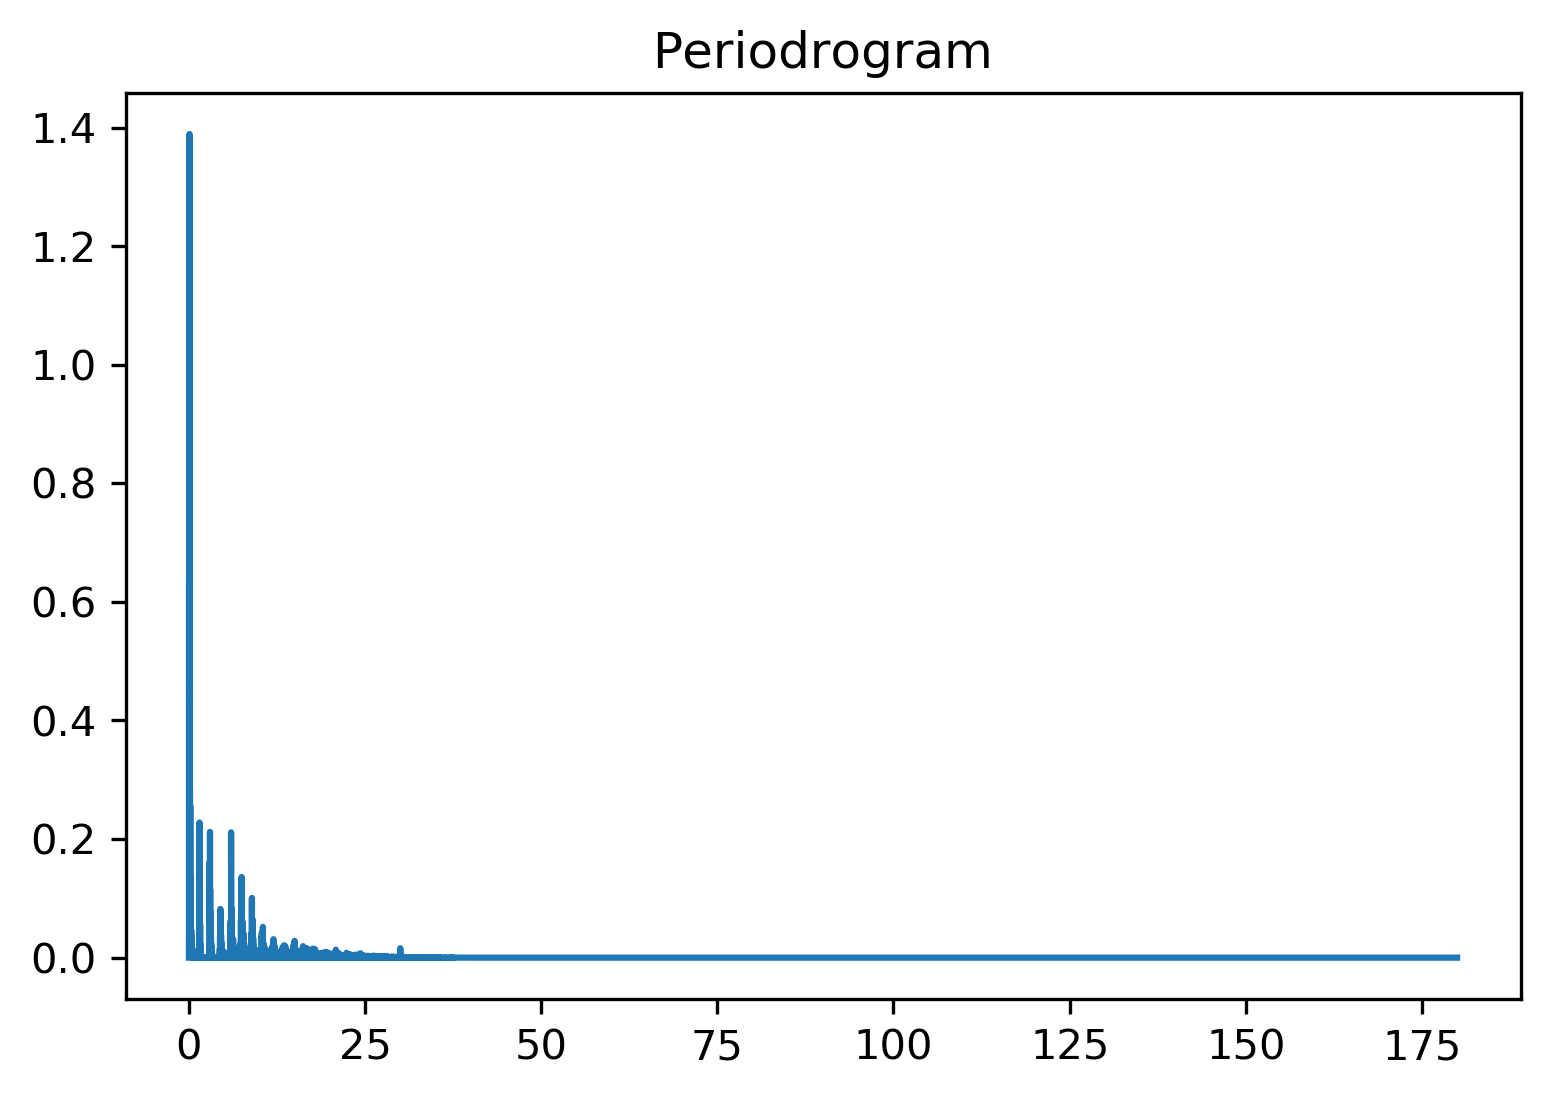

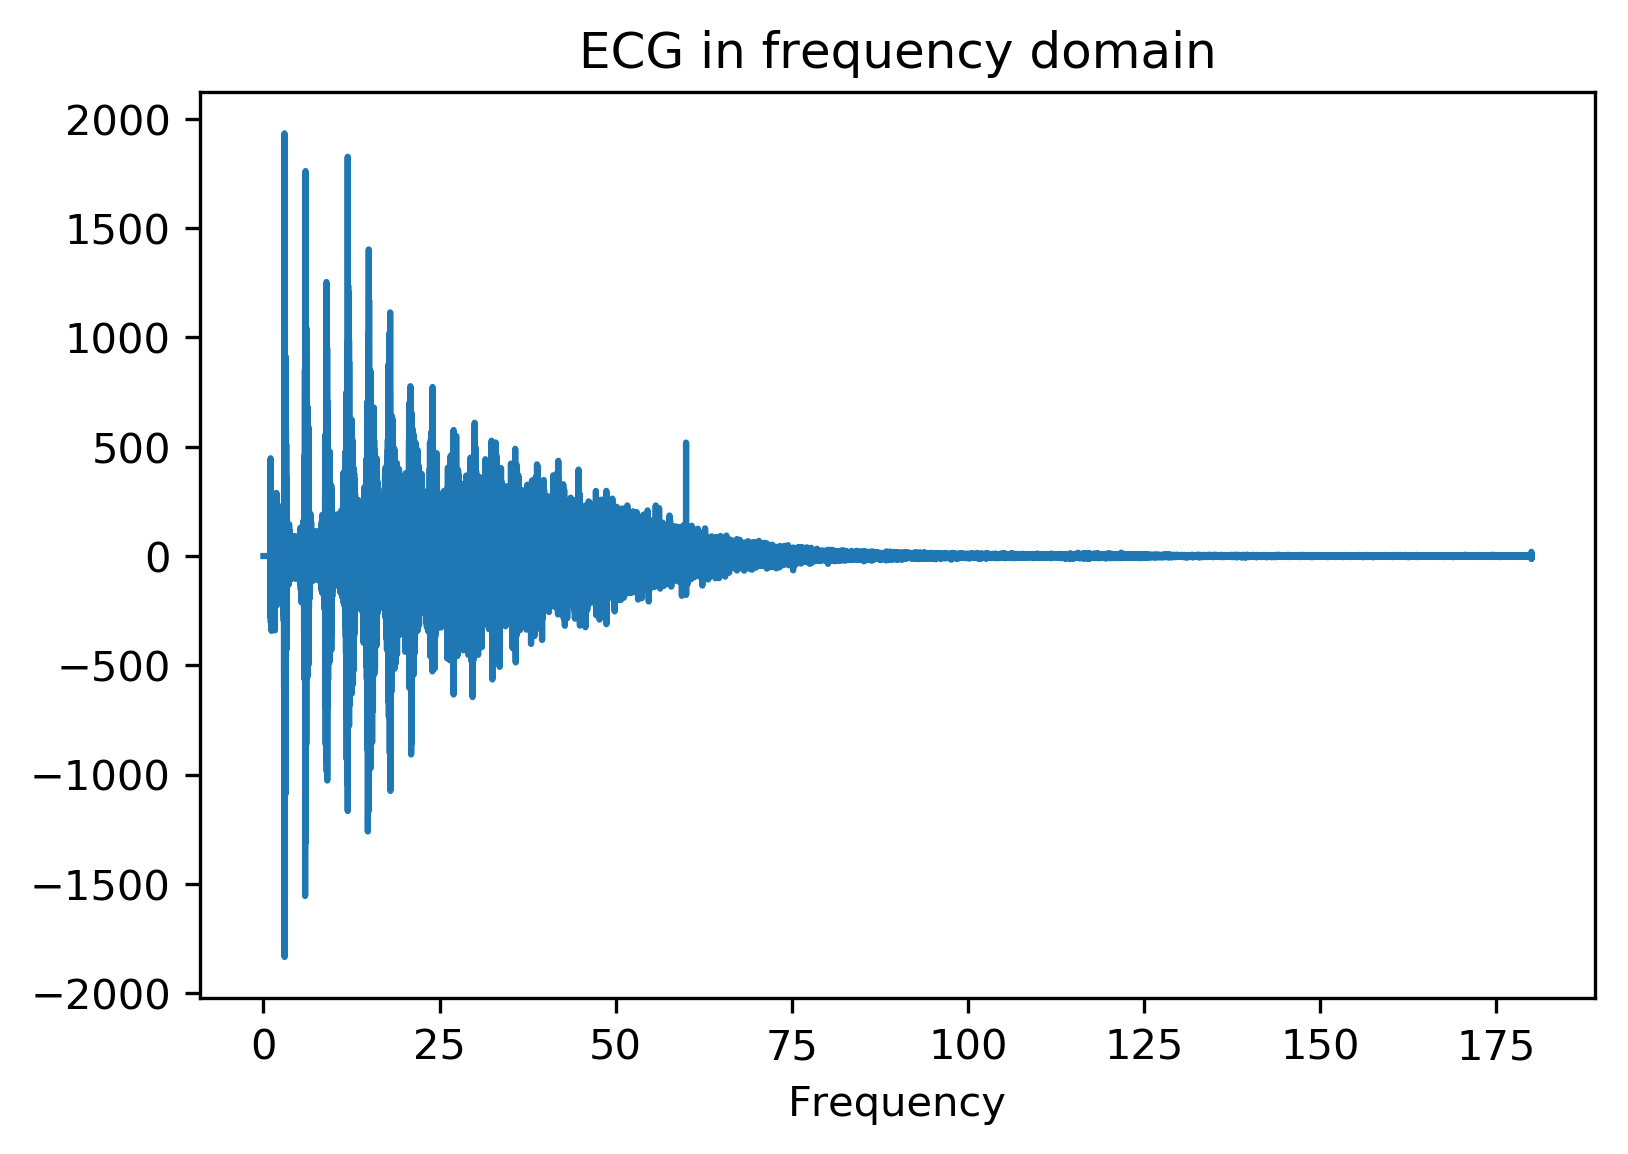

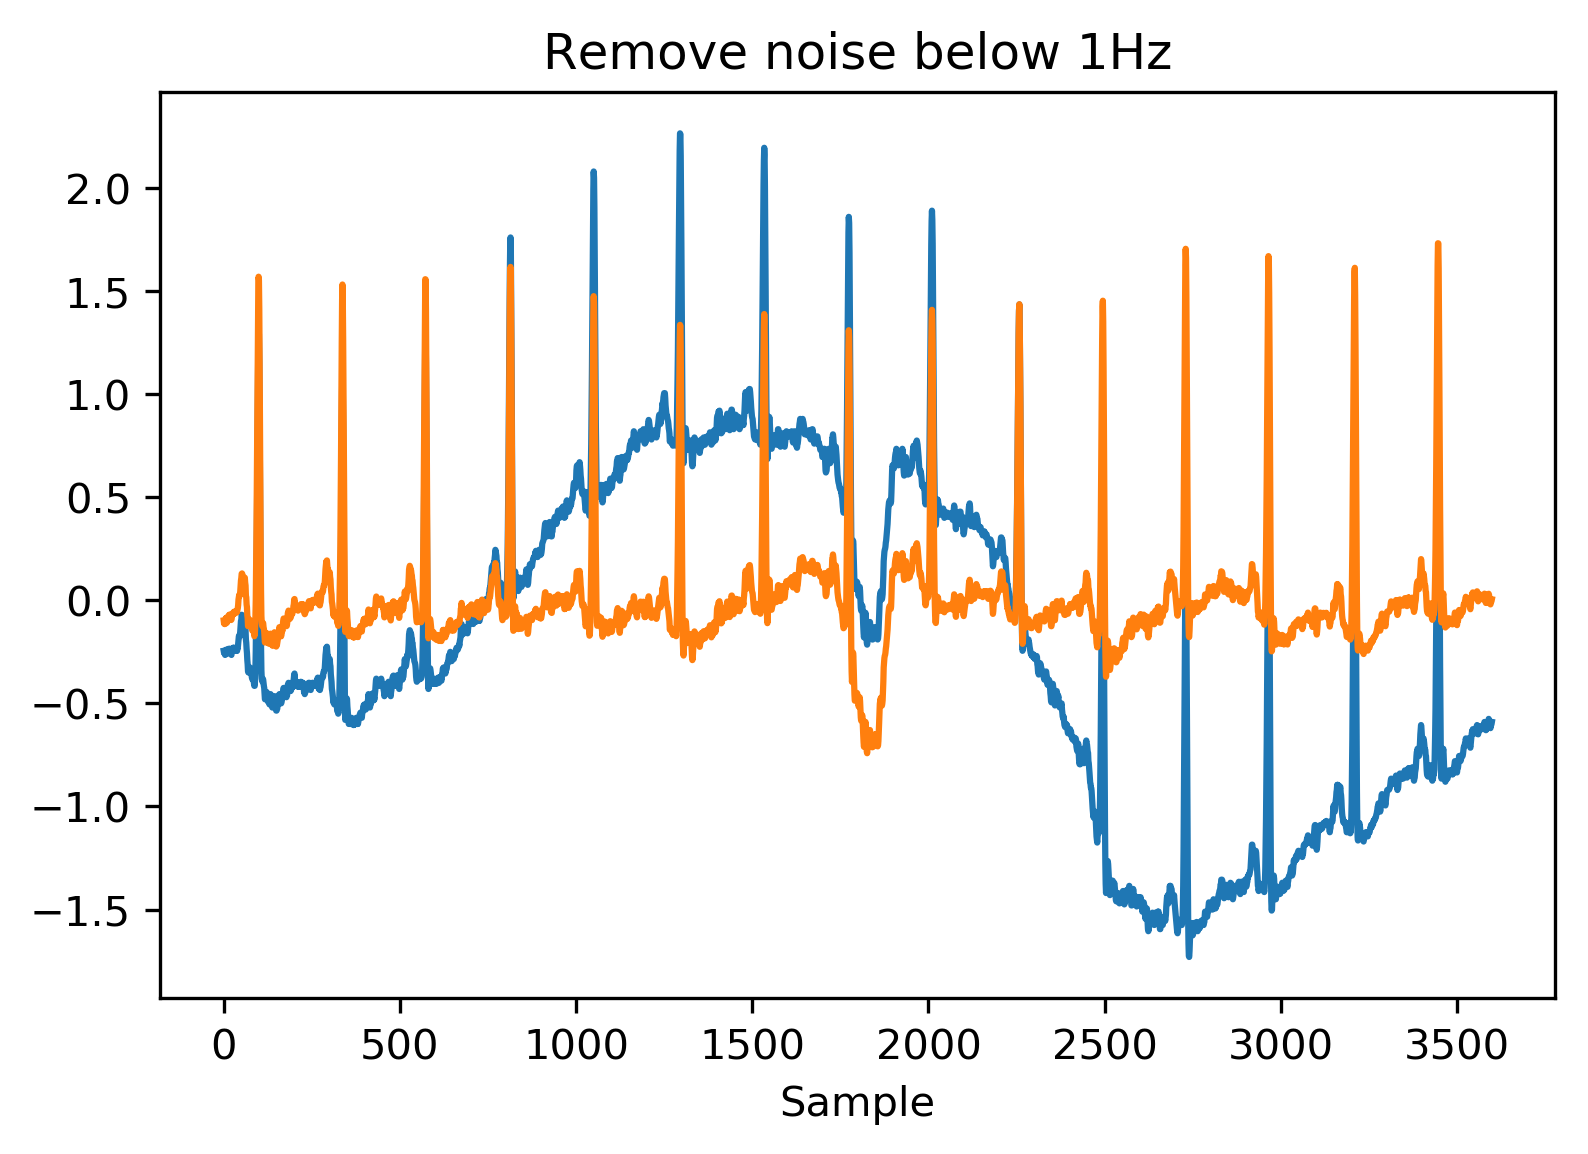

In [4]:
# Load all mitdb records
full_data = mitdb.get_records(mitdb.full_ds)

# Slice all data into time frames of size 10 min + 5 min
from arrhythmia.experimental.common import slice_records
from arrhythmia.model.helpers import beat_types
from arrhythmia.model.preprocessing import downsample

pred_minutes = 5
post_minutes = 2

pred_window = 360 * 60 * pred_minutes
post_window = 360 * 60 * post_minutes

slicer = slice_records(full_data, pred_window, post_window, increment=360 * 30, check_pred=False)

# Convert loaded data into model input and expected classes
def to_classes(labels, threshold=1):
    targets = np.zeros(len(beat_types[1:-1]), dtype=np.float32)
    for i, bt in enumerate(beat_types[1:-1]):
        count = np.sum(labels == bt.symbol)
        targets[i] = 1.0 if count >= threshold else 0.0
    return targets

# Downsample data to reduce number of features and remove high f. noise at the same time
frequency = 360
target_frequency = 360
input_data = []
classes = []
for i, (pred, post) in enumerate(slicer):
    data = pred[0]
    cl = to_classes(post[2])
    if target_frequency != frequency:
        if i == 0:
            plt.plot(data[:frequency*3])
        data = downsample(data, frequency // target_frequency)
        if i == 0:
            back_x = np.arange(0, frequency*3, frequency // target_frequency)
            plt.plot(back_x, data[:target_frequency*3])
            plt.title('Downsample to {}Hz'.format(target_frequency))
            plt.xlabel('Sample')
            plt.show()

    input_data.append(data)
    classes.append(cl)

frequency = target_frequency
        
input_data = np.array(input_data)
classes = np.array(classes)
        
unique, cnts = np.unique(classes, axis=0, return_counts=True)
print('Unique label sets and their count:')
for u, c in zip(unique, cnts):
    print(u, c)
print('Total of {} samples'.format(sum(cnts)))

# Plot periodogram
periodogram = True
if periodogram:
    from scipy.signal import periodogram
    f, pxx = periodogram(input_data[-2], frequency, return_onesided=True)
    plt.plot(f, pxx)
    plt.title('Periodrogram')
    plt.show()

# Remove low frequency noise using FFT->IFFT
fft = True
replace_with_fft = False
fft_threshold = 1
if fft:
    from scipy import fftpack
    after_fft = fftpack.rfft(input_data)

    fft_freq = fftpack.fftfreq(after_fft.shape[-1], d=1/frequency)

    after_fft[:, np.abs(fft_freq) < fft_threshold] = 0
    halfsize = after_fft.shape[1]//2
    plt.plot(fft_freq[:halfsize], after_fft[-2, :halfsize].real)
    plt.title('ECG in frequency domain')
    plt.xlabel('Frequency')
    plt.show()
    
    if not replace_with_fft:
        plt.plot(input_data[-2][:frequency*10])
        input_data = fftpack.irfft(after_fft)
        plt.plot(input_data[-2][:frequency*10])
        plt.title('Remove noise below {}Hz'.format(fft_threshold))
        plt.xlabel('Sample')
        plt.show()
    else:
        input_data = fft_freq.real

input_data = np.array(input_data)
input_shape = input_data.shape[1:]

# Normalize input data
from arrhythmia.experimental.common import normalize_mean_std

input_data_n = normalize_mean_std(input_data)

In [5]:
from arrhythmia.experimental.common import ModelTester
import keras.backend as K
# TODO Update keras to use those metrics
#from keras.metrics import precision, recall

tester = ModelTester(input_data_n, classes, verbose=0)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

metrics = ['binary_accuracy', 'mse', precision, recall, fmeasure]

window_postfix = str(pred_minutes) + '_' + str(post_minutes)
def network_name(name):
    return 'mlp_{}_f{}_fft_win_{}_{}.hdf5'.format(name, frequency, pred_minutes, post_minutes)

## Networks:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten


def dense_network(layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = inputs
        for layer in layers:
            x = Dense(layer, activation='relu')(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

def conv_network(pool=4, layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = Reshape((*input_shape, 1))(inputs)
        for size, num in layers:
            x = Conv1D(size, num, activation='relu')(x)
            x = MaxPooling1D(pool_size=pool)(x)
        x = Flatten()(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

Testing dense model with layers: [10, 50, 10]
Trained for 6 epochs
loss: 0.6051, binary_accuracy: 0.6795, mean_squared_error: 0.2071, precision: 0.5174, recall: 0.2527, fmeasure: 0.3300
Trained for 9 epochs
loss: 0.6098, binary_accuracy: 0.6731, mean_squared_error: 0.2097, precision: 0.5067, recall: 0.2866, fmeasure: 0.3496
Trained for 9 epochs
loss: 0.5927, binary_accuracy: 0.6860, mean_squared_error: 0.2026, precision: 0.4981, recall: 0.4069, fmeasure: 0.4256
Trained for 10 epochs
loss: 0.5876, binary_accuracy: 0.6828, mean_squared_error: 0.2008, precision: 0.4772, recall: 0.4292, fmeasure: 0.4407
Trained for 6 epochs
loss: 0.6178, binary_accuracy: 0.6691, mean_squared_error: 0.2125, precision: 0.4145, recall: 0.3801, fmeasure: 0.3856
loss: 0.6026 (+/-0.0111), binary_accuracy: 0.6781 (+/-0.0062), mean_squared_error: 0.2065 (+/-0.0043), precision: 0.4828 (+/-0.0366), recall: 0.3511 (+/-0.0691), fmeasure: 0.3863 (+/-0.0425)


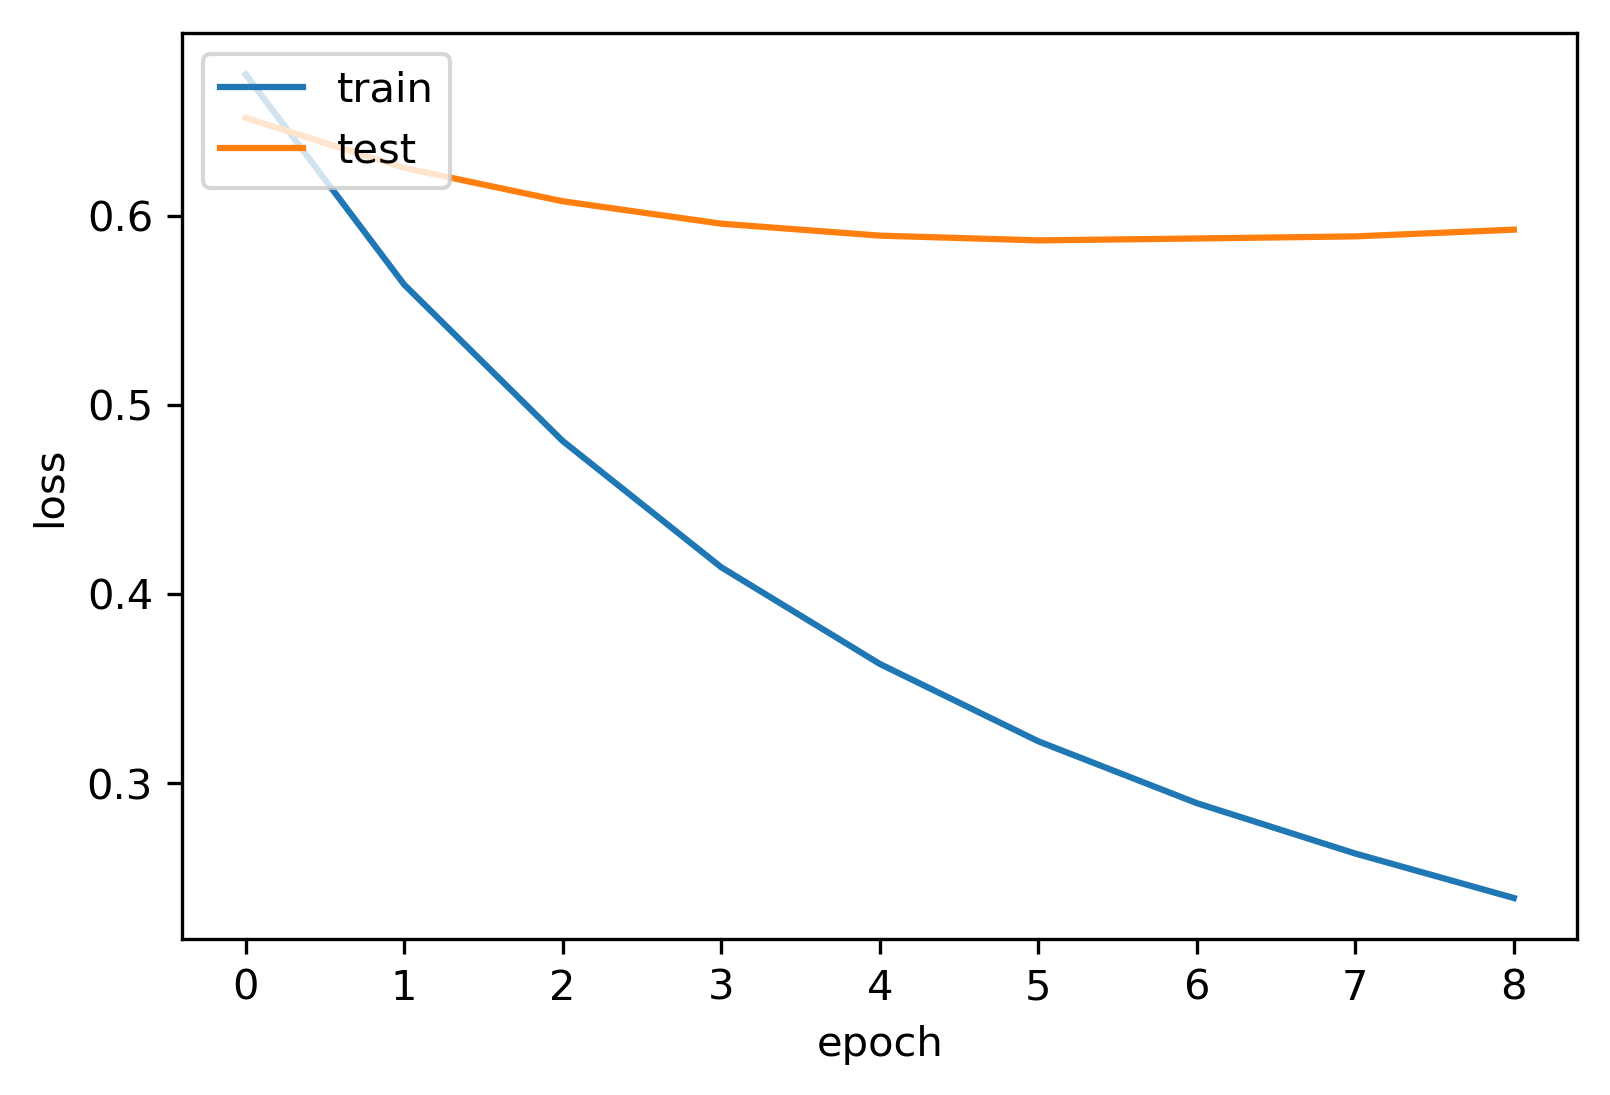

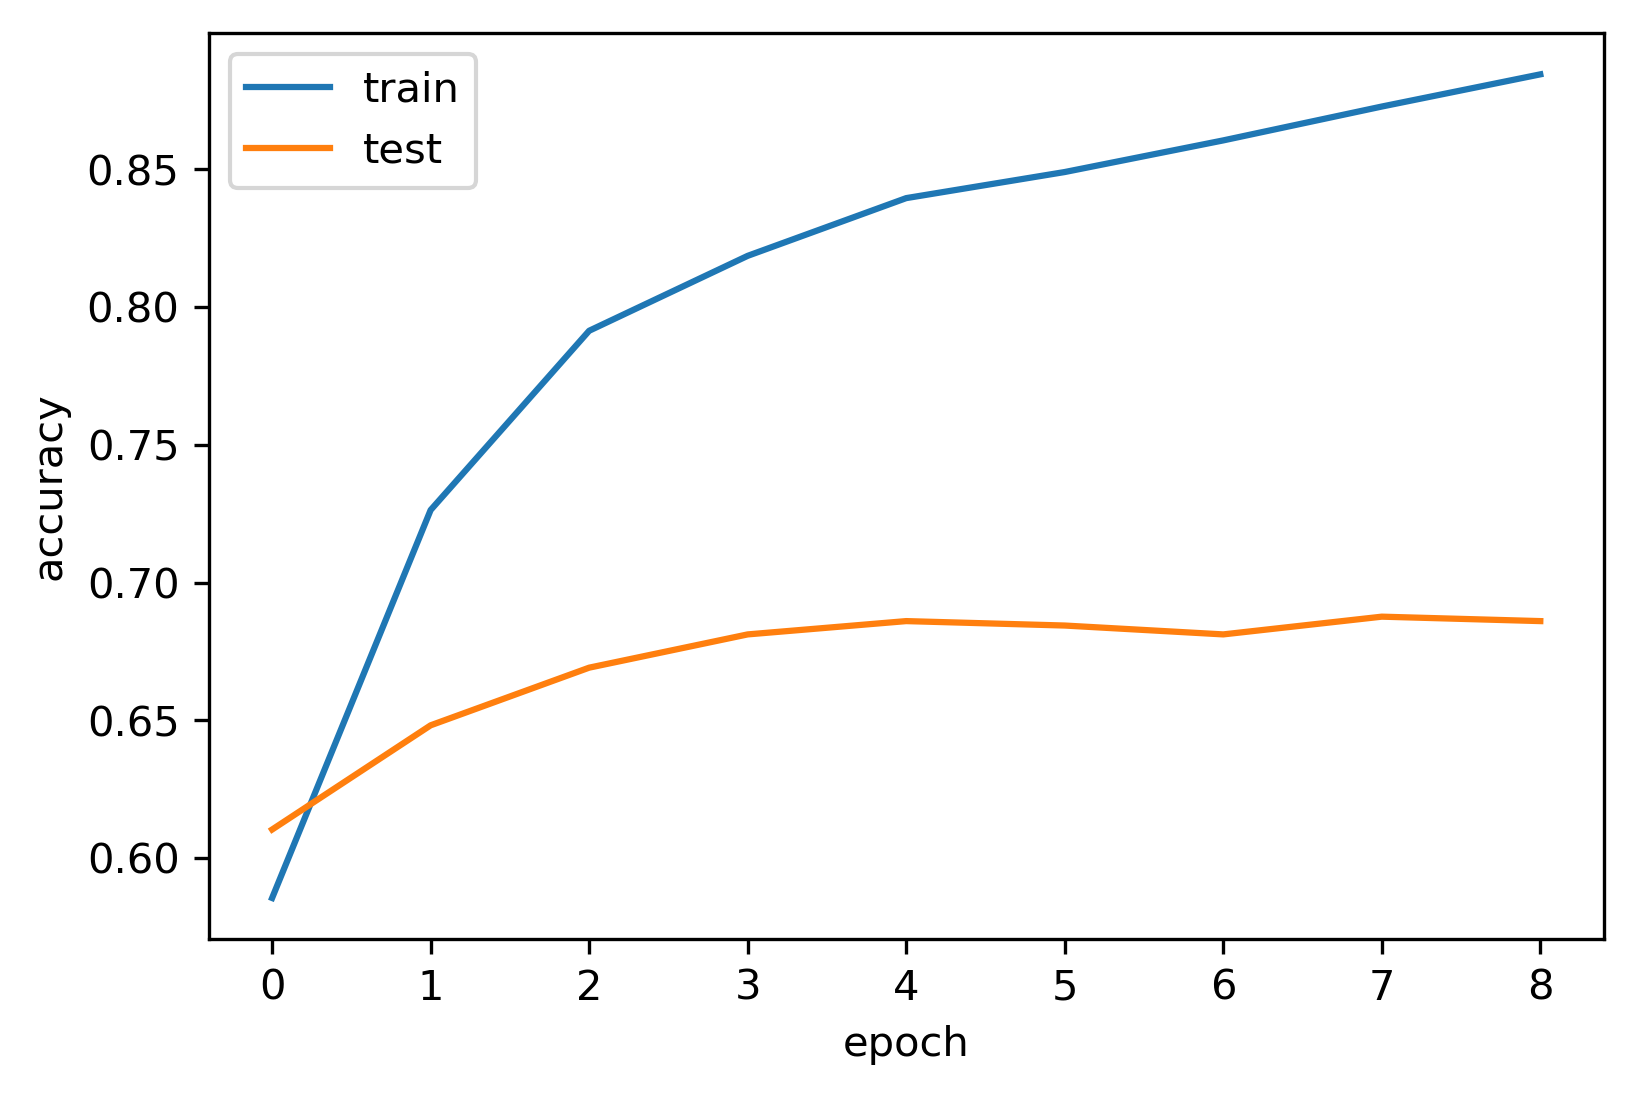

Testing dense model with layers: [100, 100]
Trained for 6 epochs
loss: 0.5997, binary_accuracy: 0.6876, mean_squared_error: 0.2031, precision: 0.4879, recall: 0.3258, fmeasure: 0.3744
Trained for 5 epochs
loss: 0.6138, binary_accuracy: 0.6860, mean_squared_error: 0.2075, precision: 0.5011, recall: 0.3266, fmeasure: 0.3736
Trained for 6 epochs
loss: 0.5952, binary_accuracy: 0.6860, mean_squared_error: 0.2010, precision: 0.4658, recall: 0.4050, fmeasure: 0.4190
Trained for 6 epochs
loss: 0.6090, binary_accuracy: 0.6715, mean_squared_error: 0.2073, precision: 0.4449, recall: 0.3755, fmeasure: 0.3923
Trained for 5 epochs
loss: 0.6119, binary_accuracy: 0.6925, mean_squared_error: 0.2077, precision: 0.4324, recall: 0.4060, fmeasure: 0.3977
loss: 0.6059 (+/-0.0072), binary_accuracy: 0.6847 (+/-0.0070), mean_squared_error: 0.2053 (+/-0.0027), precision: 0.4664 (+/-0.0256), recall: 0.3678 (+/-0.0357), fmeasure: 0.3914 (+/-0.0168)


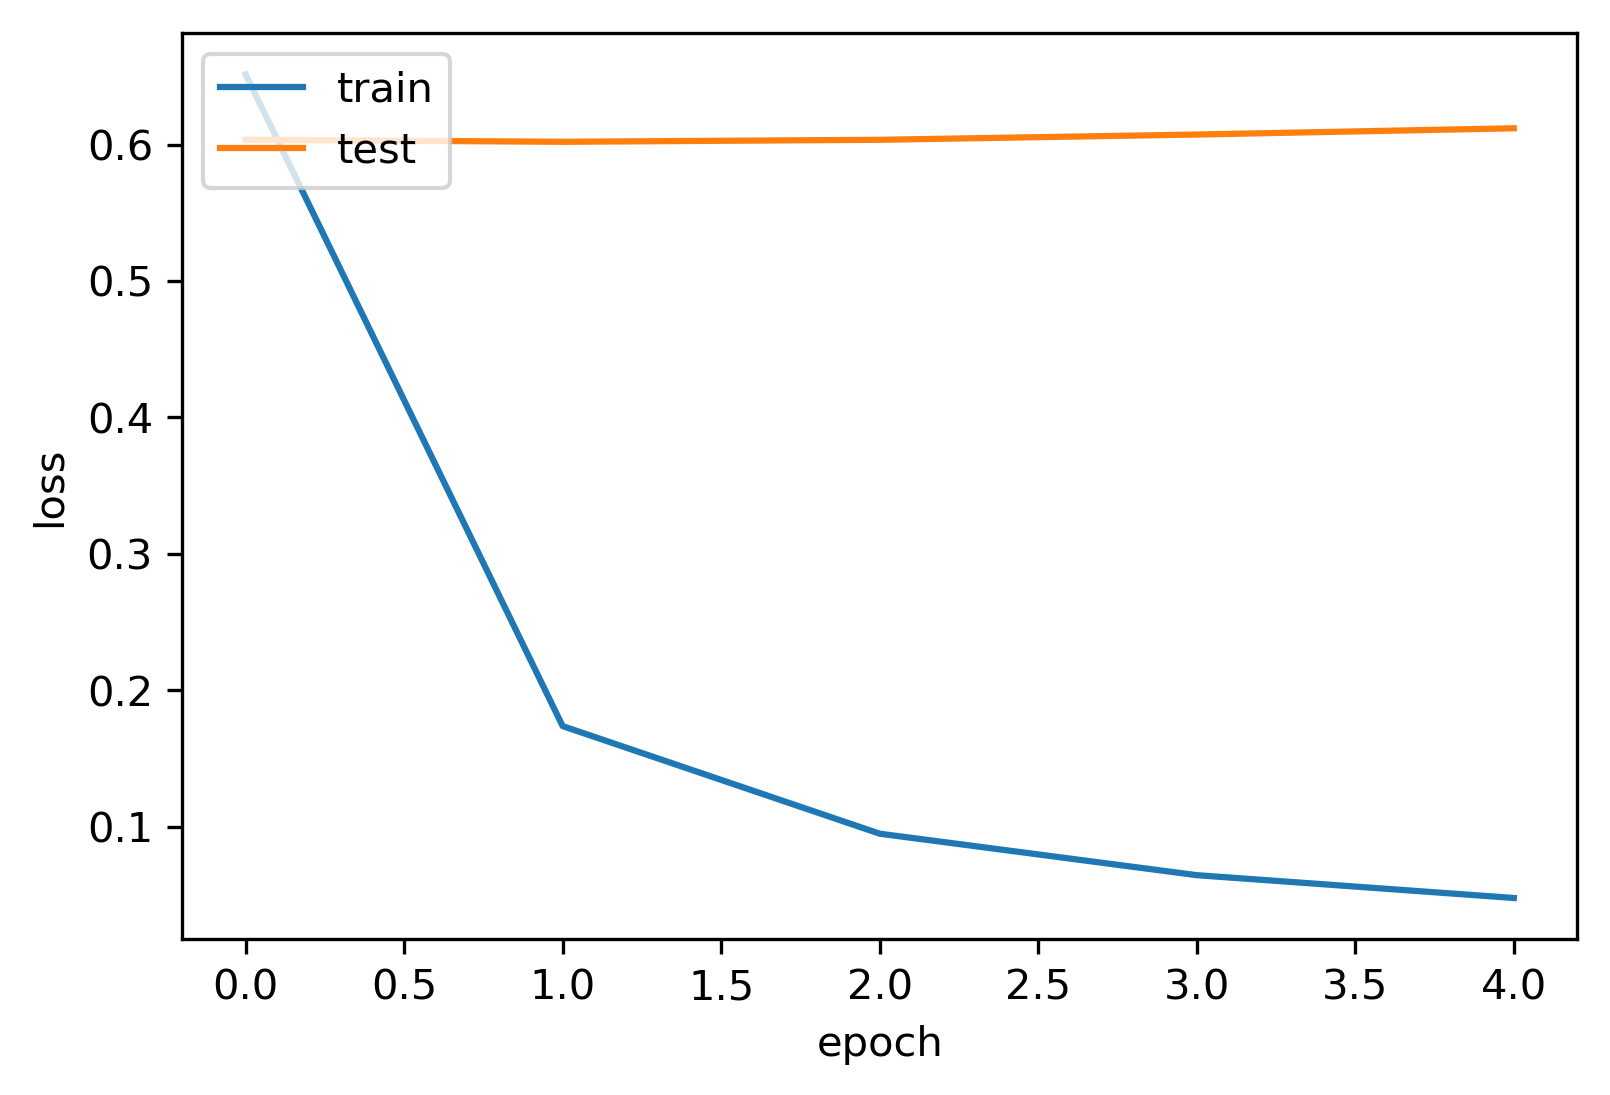

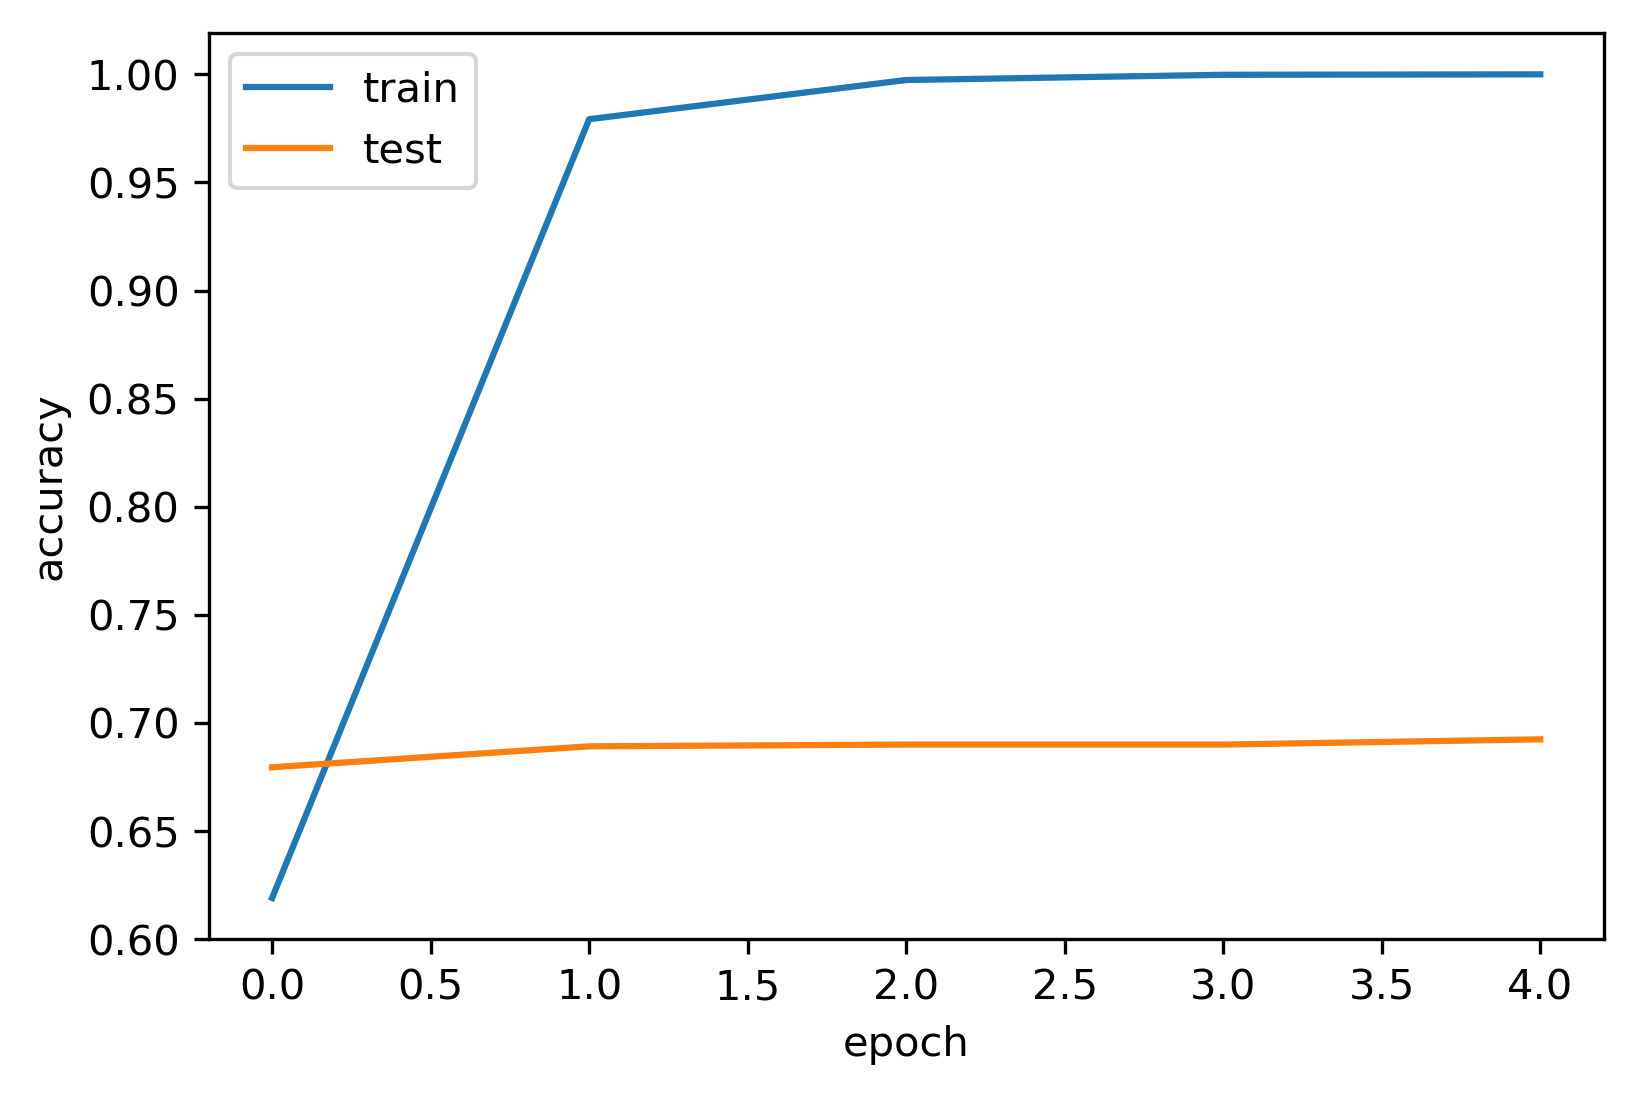

Testing dense model with layers: [100, 200, 100]
Trained for 6 epochs
loss: 0.6054, binary_accuracy: 0.6771, mean_squared_error: 0.2032, precision: 0.4776, recall: 0.3090, fmeasure: 0.3597
Trained for 5 epochs
loss: 0.5999, binary_accuracy: 0.6667, mean_squared_error: 0.2073, precision: 0.4666, recall: 0.3173, fmeasure: 0.3629
Trained for 5 epochs
loss: 0.5708, binary_accuracy: 0.7077, mean_squared_error: 0.1919, precision: 0.5110, recall: 0.3379, fmeasure: 0.3947
Trained for 6 epochs
loss: 0.5532, binary_accuracy: 0.7135, mean_squared_error: 0.1864, precision: 0.5211, recall: 0.4643, fmeasure: 0.4743
Trained for 7 epochs
loss: 0.5443, binary_accuracy: 0.7175, mean_squared_error: 0.1839, precision: 0.4665, recall: 0.4524, fmeasure: 0.4531
loss: 0.5747 (+/-0.0244), binary_accuracy: 0.6965 (+/-0.0206), mean_squared_error: 0.1945 (+/-0.0092), precision: 0.4886 (+/-0.0230), recall: 0.3762 (+/-0.0679), fmeasure: 0.4089 (+/-0.0468)


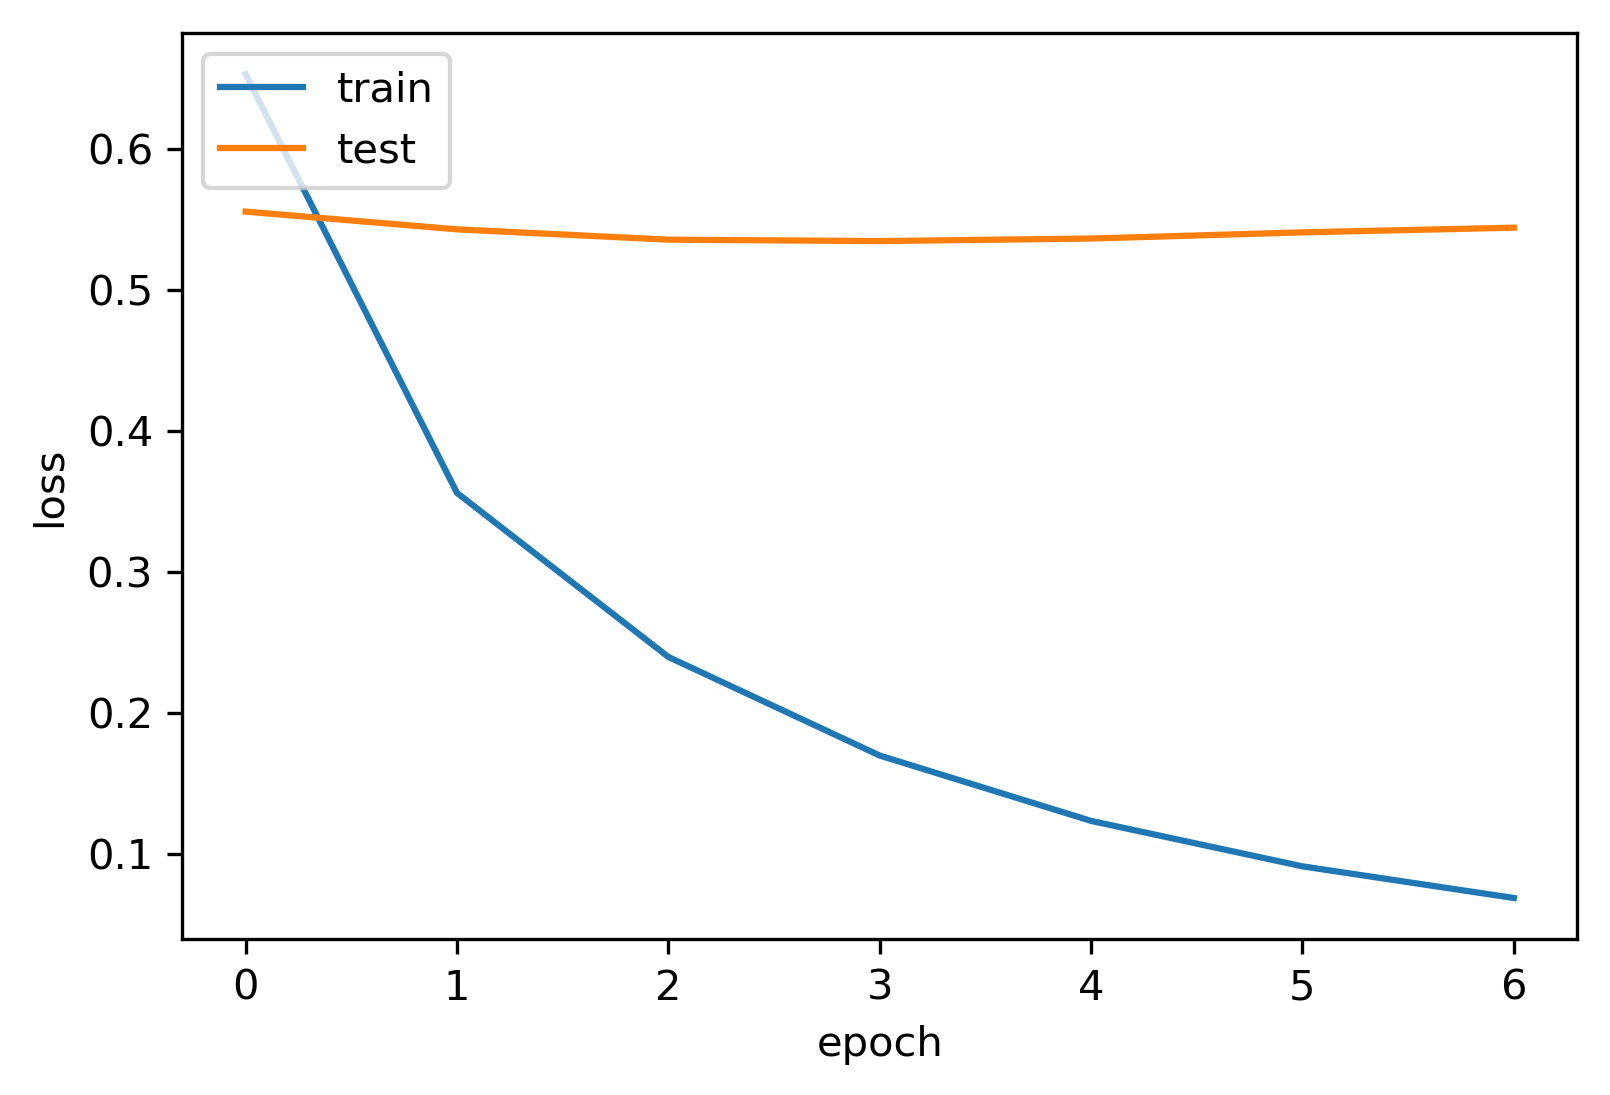

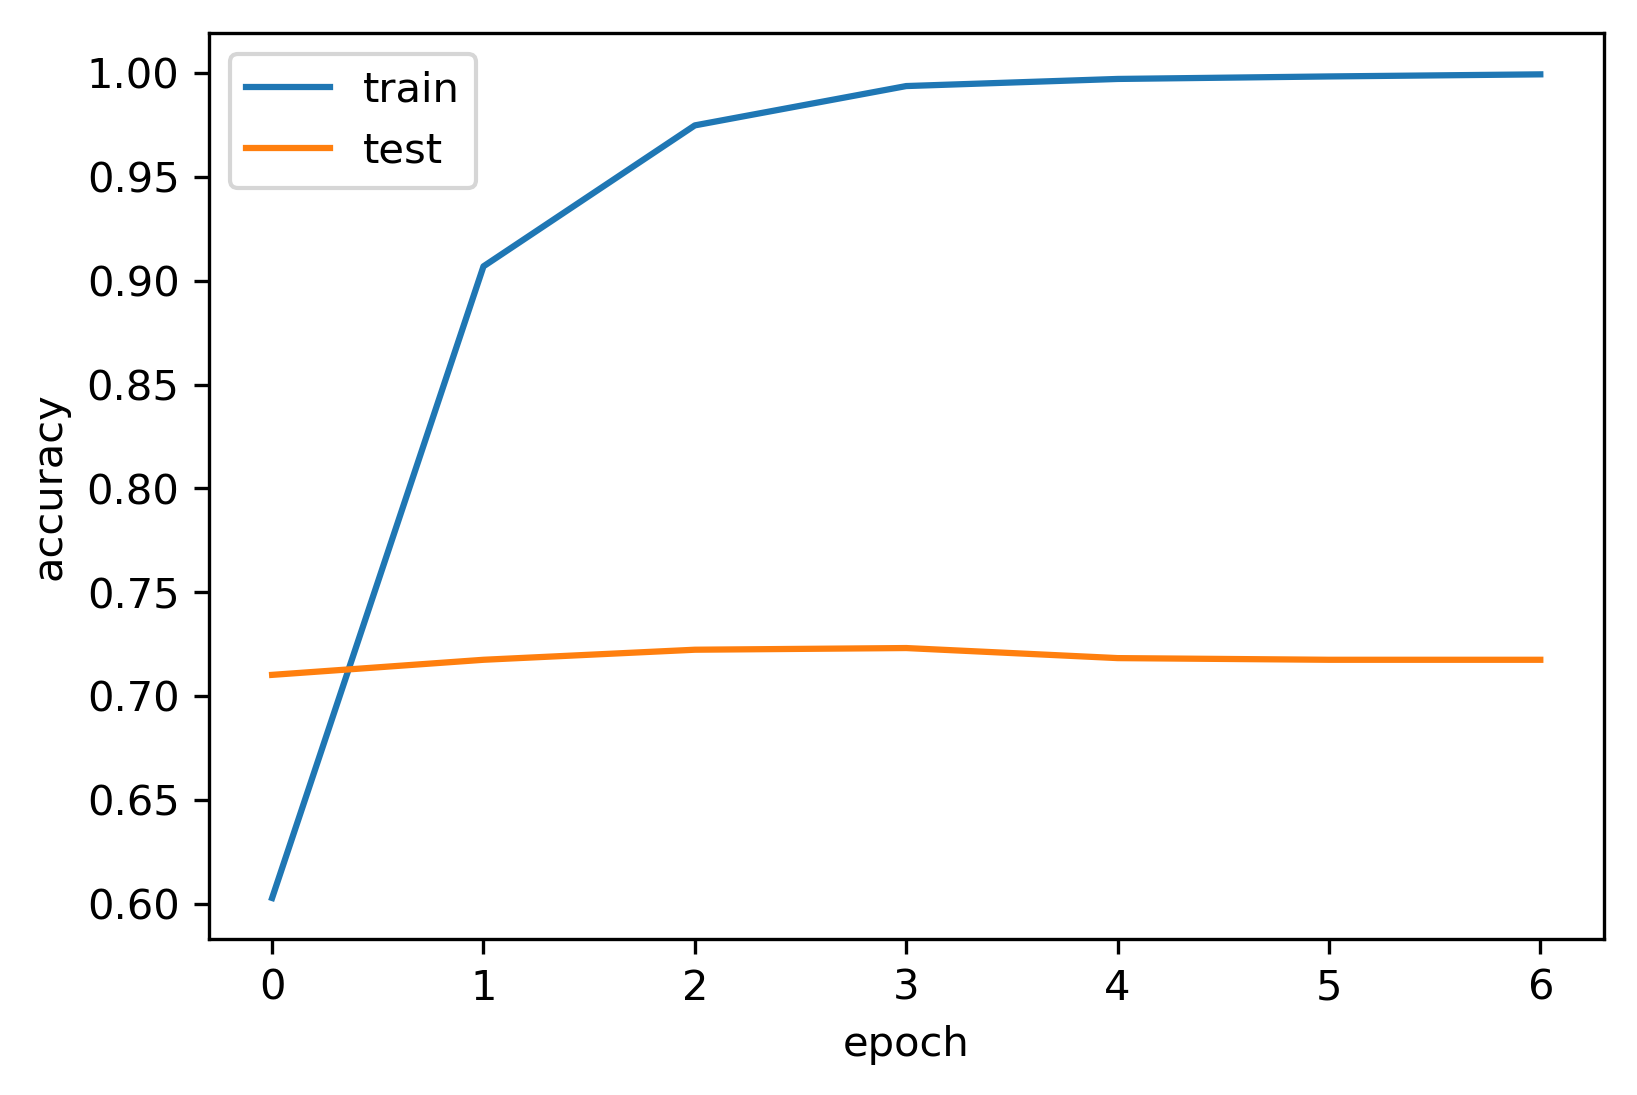

In [6]:
import itertools

considered_widths = [
    [10, 50, 10],
    [100, 100],
    [100, 200, 100]
]

for widths in considered_widths:
    print('Testing dense model with layers: {}'.format(widths))
    filename = network_name('dense_' + '_'.join([str(w) for w in widths]))
    simple_trained = tester.test_model(dense_network(widths), max_epochs=50)
    # Dense networks have very poor results and easly overfit - we disable saving them
    #simple_trained.save(filename)

Test convolutional network with parameters {'pool': 16, 'layers': [(4, 16), (16, 16)]}:
Trained for 20 epochs
loss: 0.9596, binary_accuracy: 0.6707, mean_squared_error: 0.2568, precision: 0.4842, recall: 0.9250, fmeasure: 0.6170
Trained for 19 epochs
loss: 0.3578, binary_accuracy: 0.8567, mean_squared_error: 0.1129, precision: 0.7536, recall: 0.7277, fmeasure: 0.7339
Trained for 25 epochs
loss: 0.3753, binary_accuracy: 0.8333, mean_squared_error: 0.1154, precision: 0.6822, recall: 0.8163, fmeasure: 0.7357
Trained for 20 epochs
loss: 0.3525, binary_accuracy: 0.8741, mean_squared_error: 0.1015, precision: 0.8667, recall: 0.6901, fmeasure: 0.7441
Trained for 12 epochs
loss: 0.3988, binary_accuracy: 0.8224, mean_squared_error: 0.1262, precision: 0.8535, recall: 0.3752, fmeasure: 0.4969
loss: 0.4888 (+/-0.2360), binary_accuracy: 0.8114 (+/-0.0726), mean_squared_error: 0.1426 (+/-0.0577), precision: 0.7280 (+/-0.1394), recall: 0.7069 (+/-0.1845), fmeasure: 0.6655 (+/-0.0965)


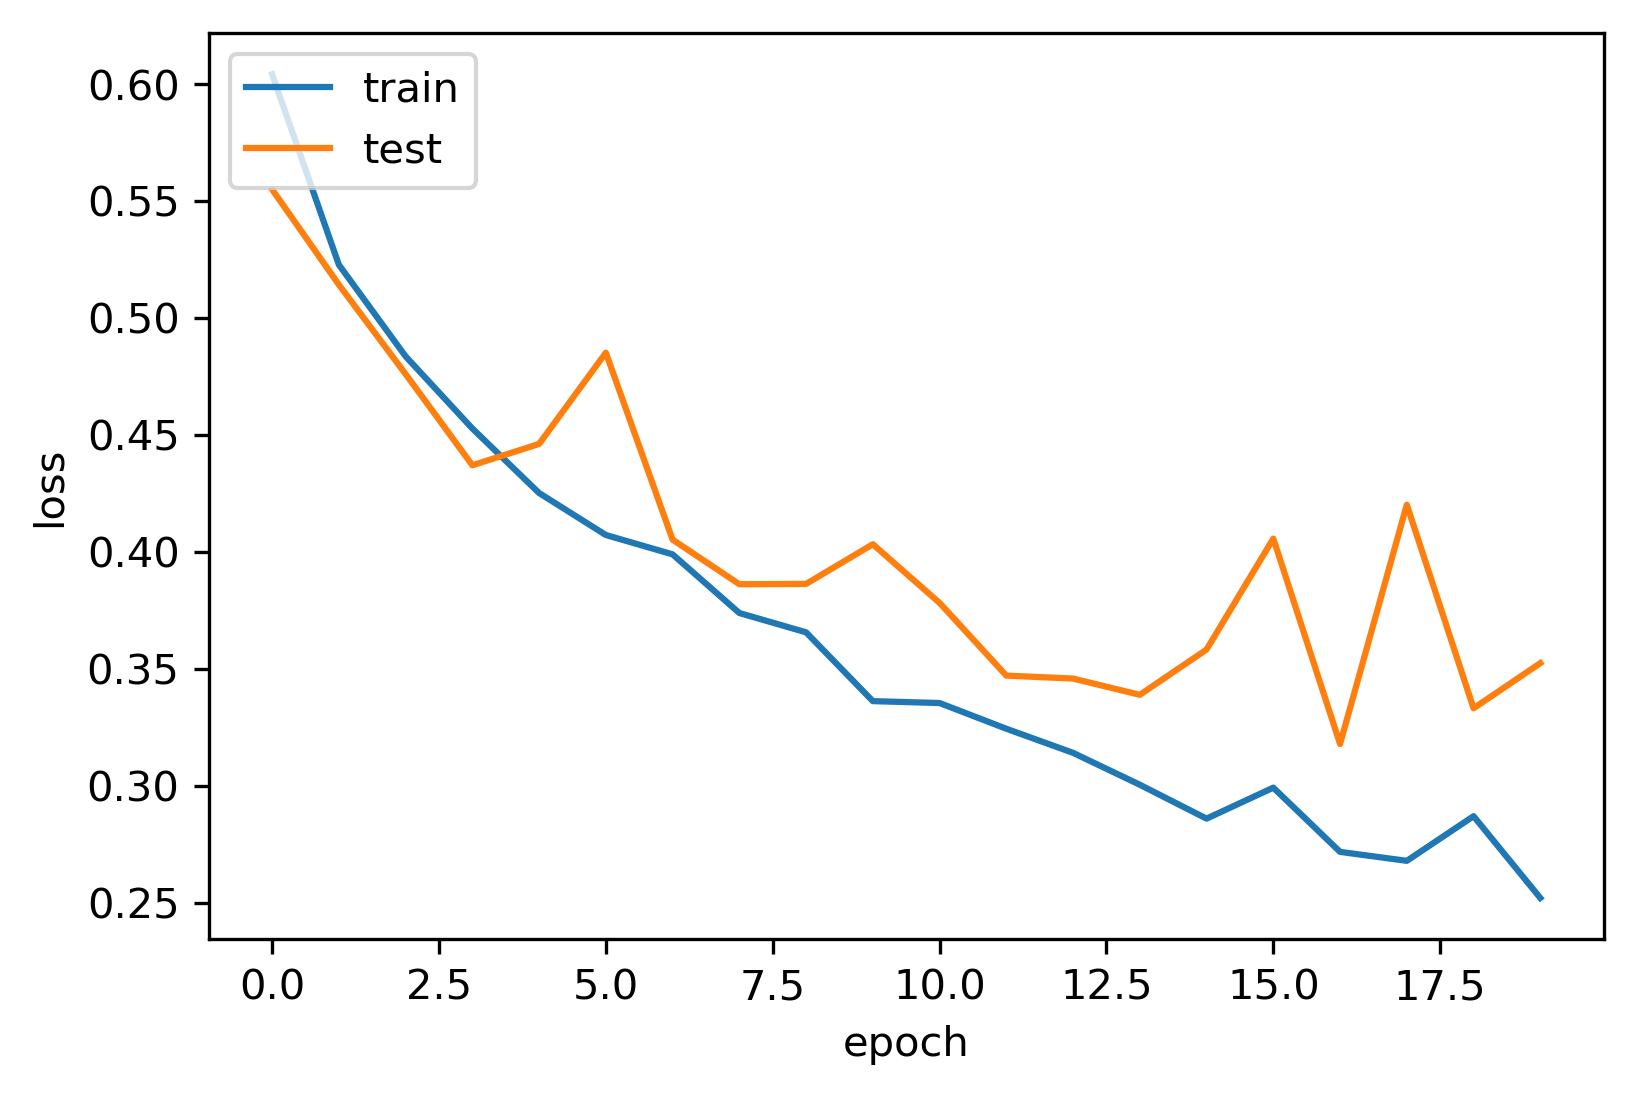

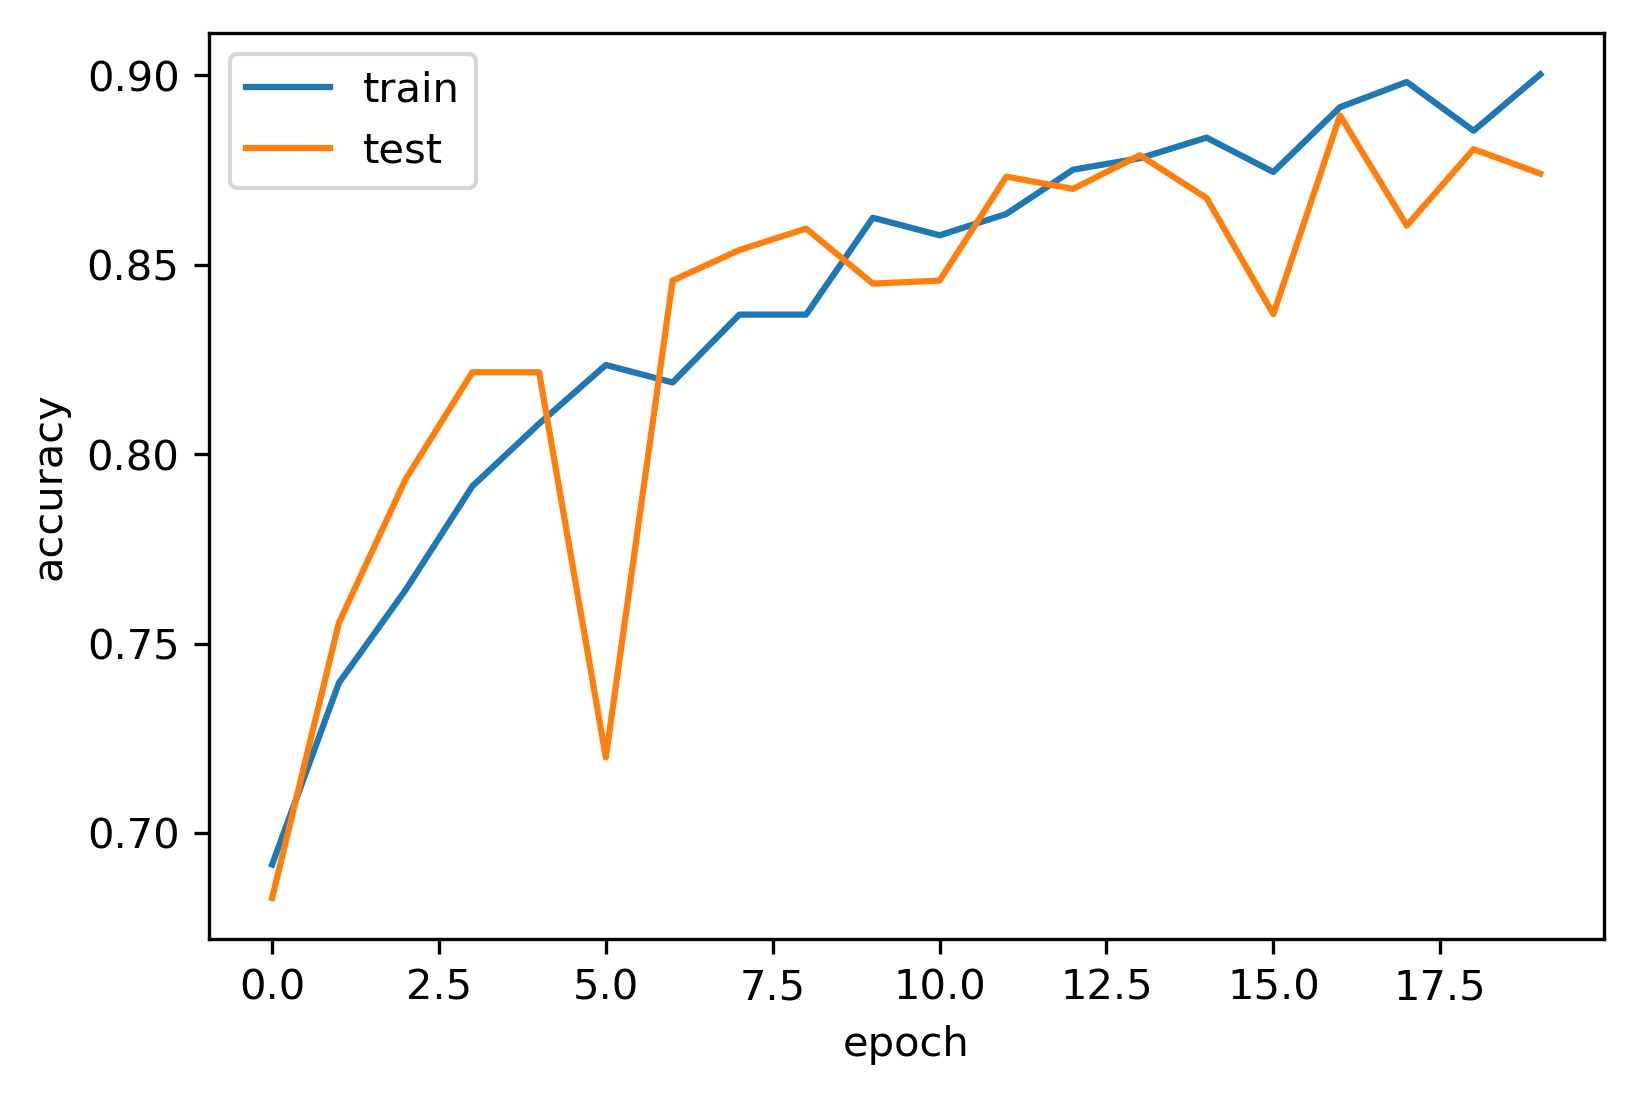

Test convolutional network with parameters {'pool': 16, 'layers': [(32, 16), (16, 16)]}:
Trained for 8 epochs
loss: 0.4421, binary_accuracy: 0.8229, mean_squared_error: 0.1411, precision: 0.6934, recall: 0.7324, fmeasure: 0.6947
Trained for 14 epochs
loss: 0.3490, binary_accuracy: 0.8567, mean_squared_error: 0.1071, precision: 0.8682, recall: 0.6054, fmeasure: 0.6968
Trained for 22 epochs
loss: 0.3816, binary_accuracy: 0.8559, mean_squared_error: 0.1152, precision: 0.8972, recall: 0.5790, fmeasure: 0.6726
Trained for 16 epochs
loss: 0.3992, binary_accuracy: 0.8410, mean_squared_error: 0.1204, precision: 0.7772, recall: 0.6210, fmeasure: 0.6726
Trained for 11 epochs
loss: 0.4311, binary_accuracy: 0.7659, mean_squared_error: 0.1455, precision: 0.5185, recall: 0.8454, fmeasure: 0.6316
loss: 0.4006 (+/-0.0337), binary_accuracy: 0.8285 (+/-0.0336), mean_squared_error: 0.1259 (+/-0.0149), precision: 0.7509 (+/-0.1365), recall: 0.6766 (+/-0.0993), fmeasure: 0.6737 (+/-0.0235)


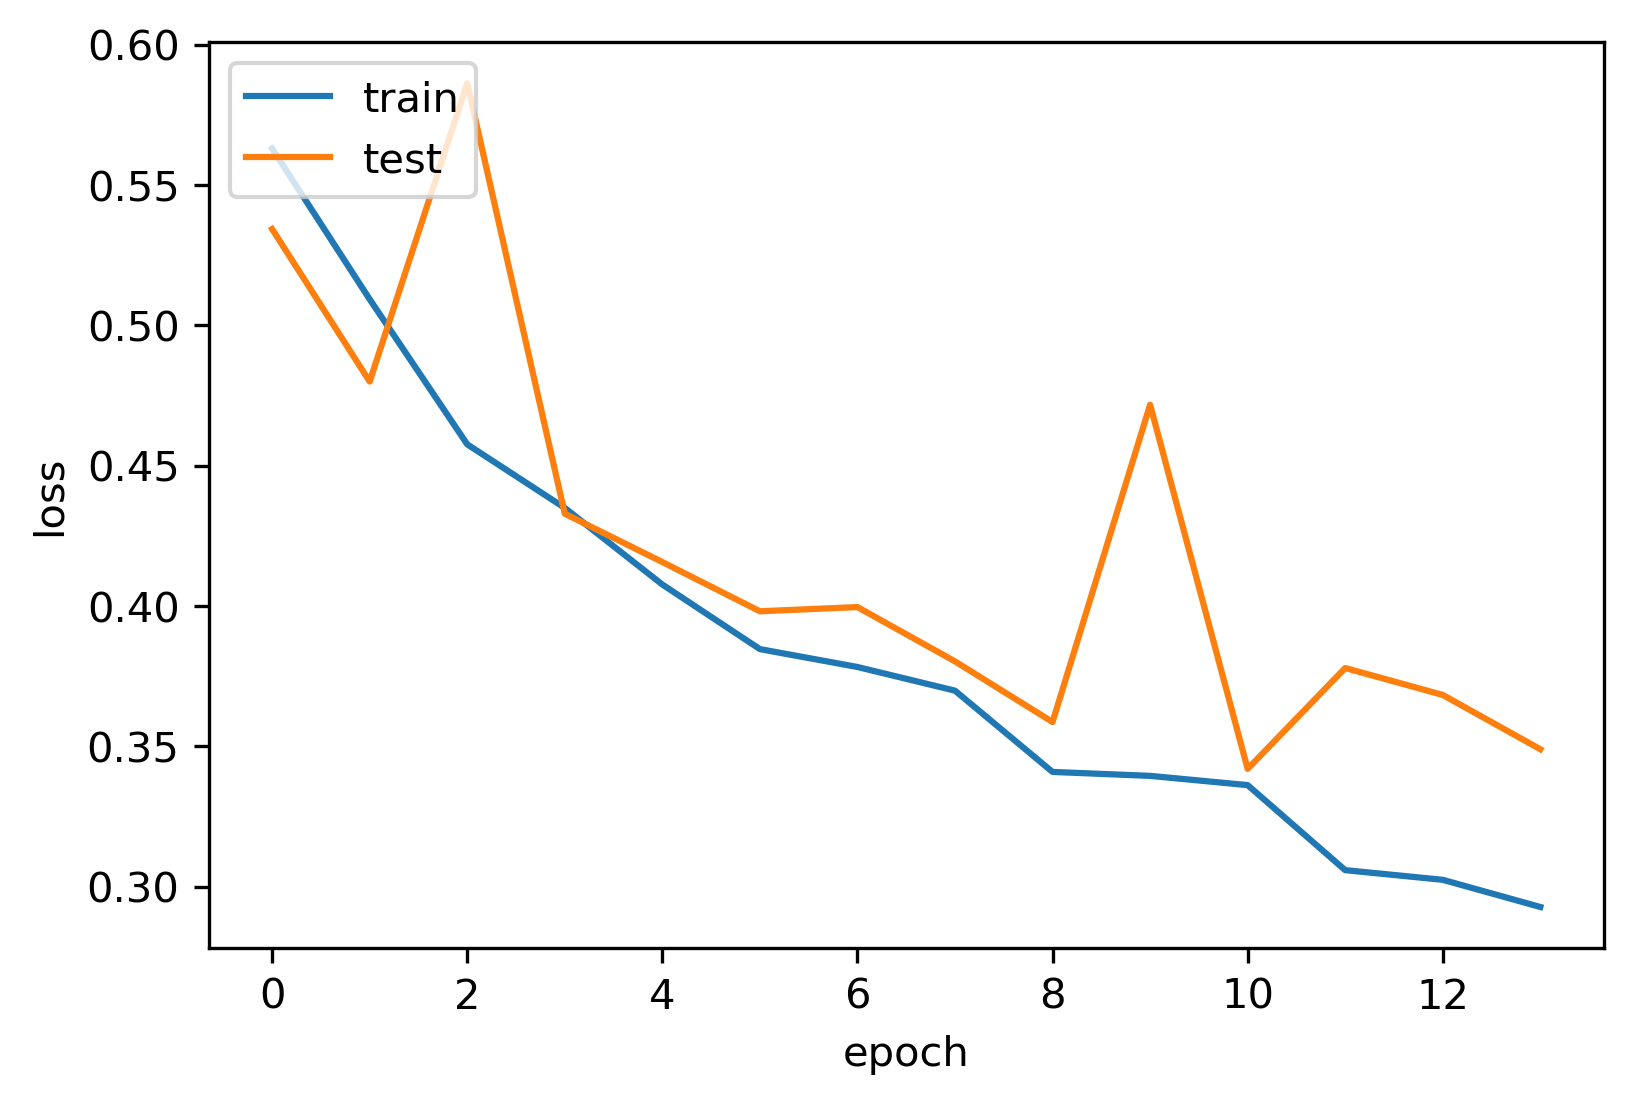

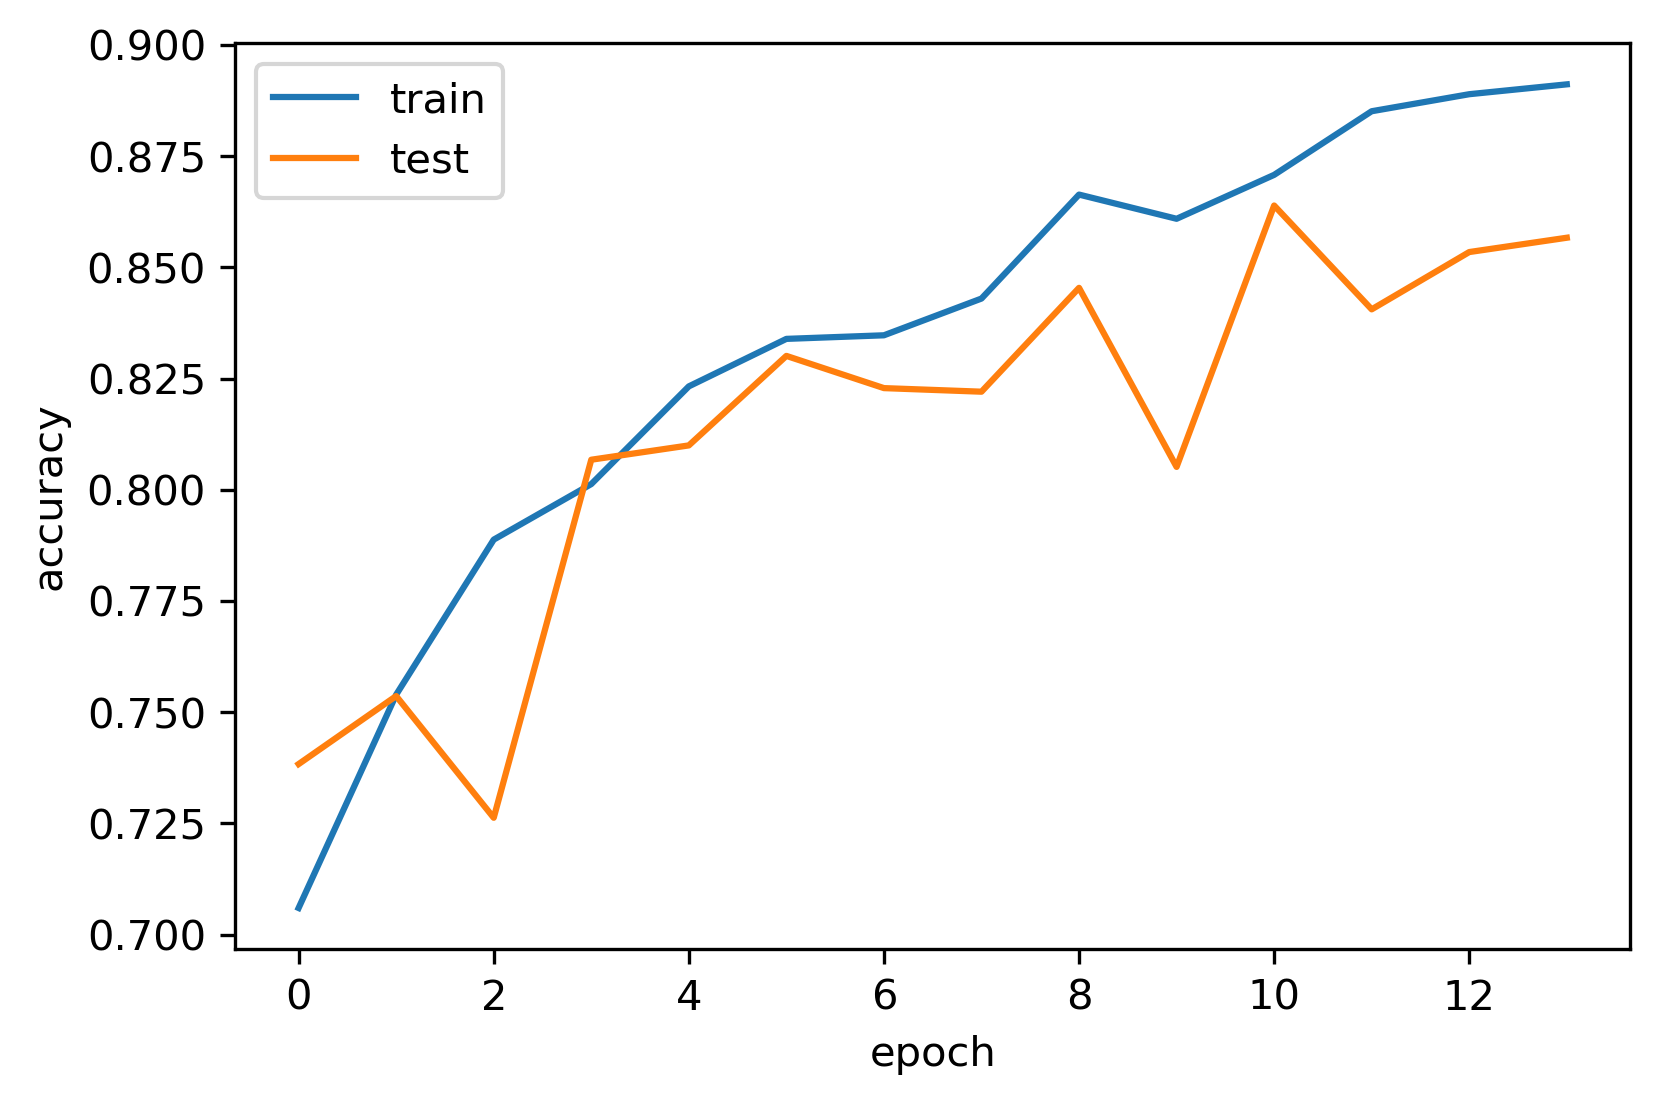

Test convolutional network with parameters {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]}:
Trained for 23 epochs
loss: 0.4164, binary_accuracy: 0.8068, mean_squared_error: 0.1340, precision: 0.7025, recall: 0.6481, fmeasure: 0.6621
Trained for 20 epochs
loss: 0.3938, binary_accuracy: 0.8213, mean_squared_error: 0.1273, precision: 0.7032, recall: 0.7098, fmeasure: 0.6971
Trained for 13 epochs
loss: 0.4102, binary_accuracy: 0.8052, mean_squared_error: 0.1339, precision: 0.8759, recall: 0.4019, fmeasure: 0.5291
Trained for 23 epochs
loss: 0.4362, binary_accuracy: 0.8152, mean_squared_error: 0.1382, precision: 0.8318, recall: 0.4064, fmeasure: 0.5359
Trained for 24 epochs
loss: 0.3959, binary_accuracy: 0.8184, mean_squared_error: 0.1243, precision: 0.6981, recall: 0.4419, fmeasure: 0.5294
loss: 0.4105 (+/-0.0154), binary_accuracy: 0.8133 (+/-0.0064), mean_squared_error: 0.1315 (+/-0.0050), precision: 0.7623 (+/-0.0761), recall: 0.5216 (+/-0.1307), fmeasure: 0.5907 (+/-0.0734)


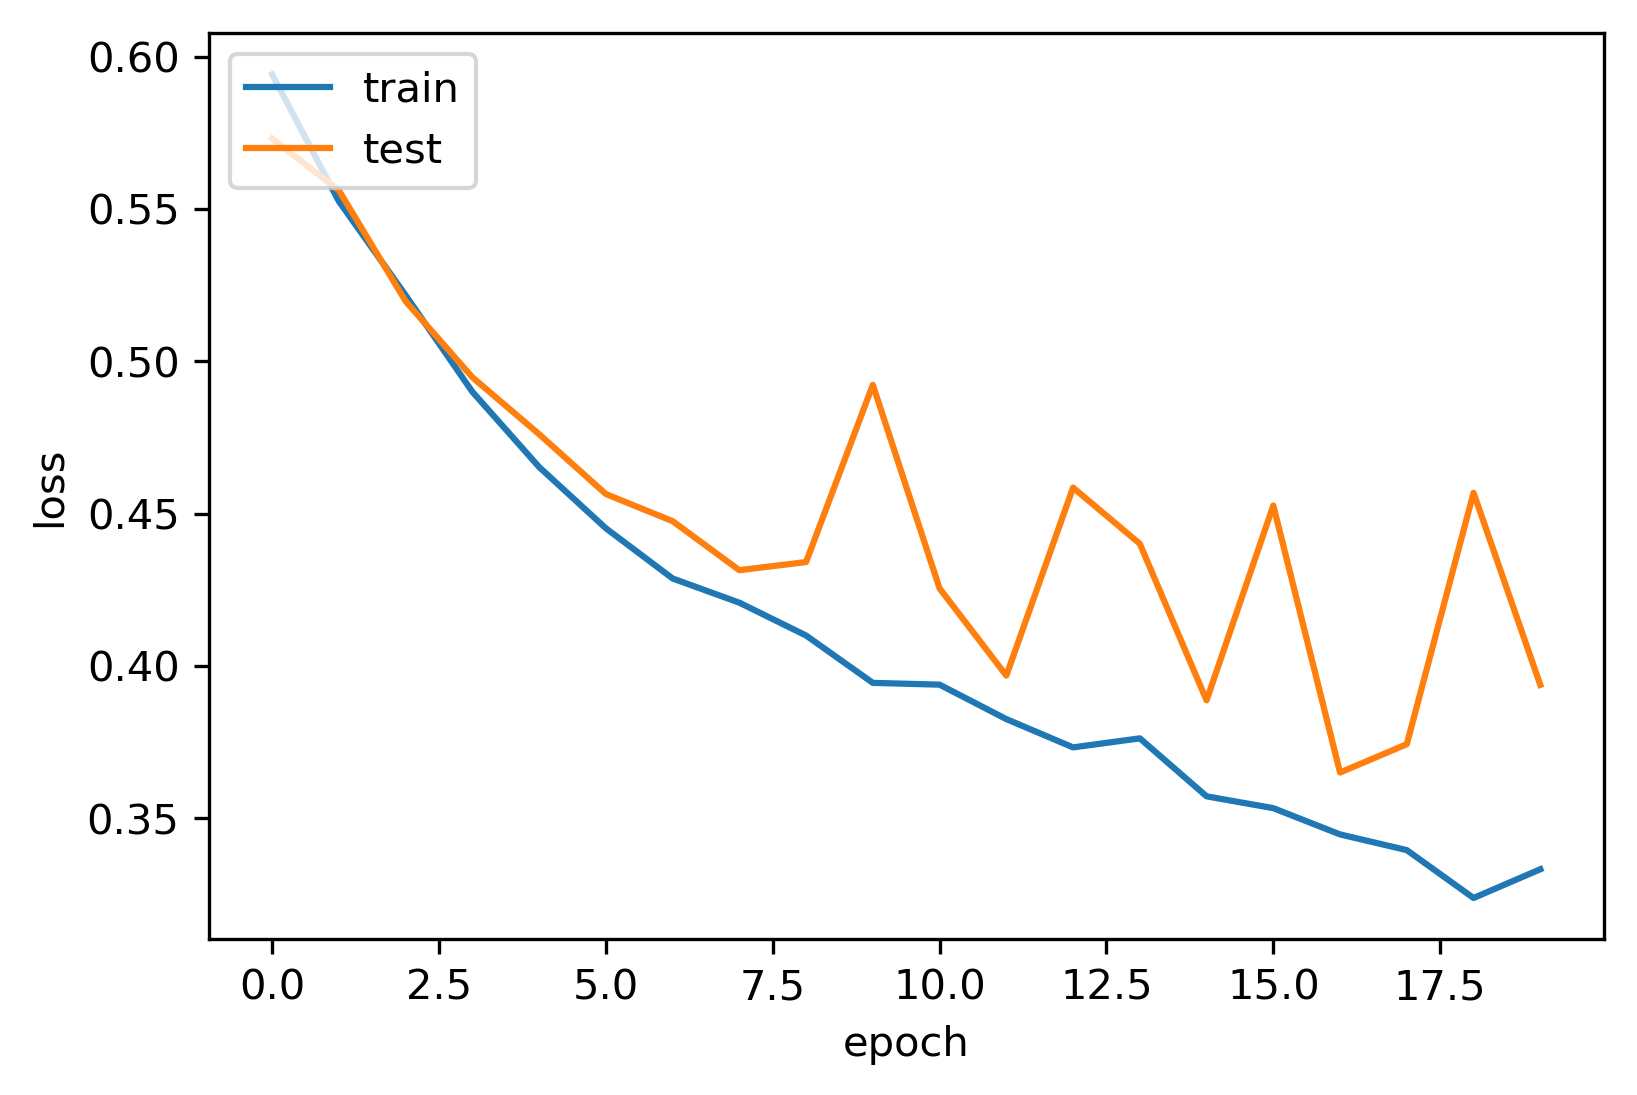

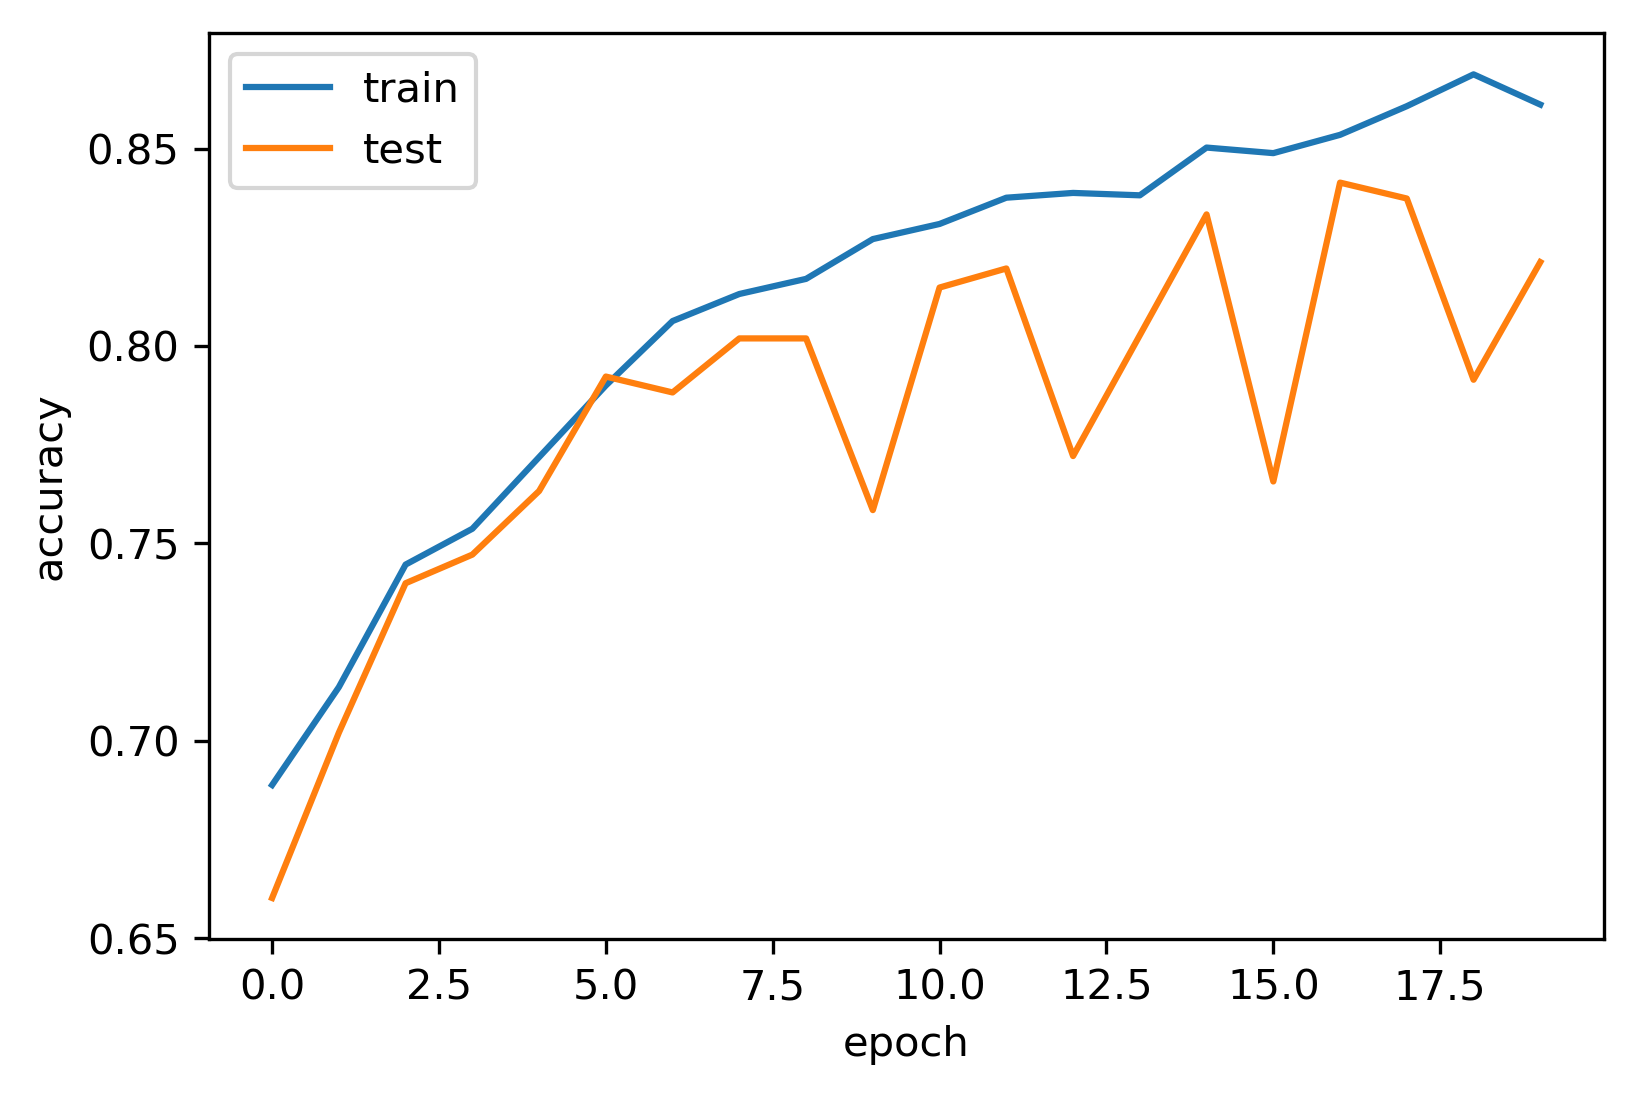

Test convolutional network with parameters {'pool': 64, 'layers': [(32, 64), (16, 64)]}:
Trained for 13 epochs
loss: 0.3501, binary_accuracy: 0.8462, mean_squared_error: 0.1105, precision: 0.7056, recall: 0.8140, fmeasure: 0.7532
Trained for 9 epochs
loss: 0.4042, binary_accuracy: 0.8213, mean_squared_error: 0.1264, precision: 0.8341, recall: 0.5359, fmeasure: 0.6415
Trained for 14 epochs
loss: 0.5530, binary_accuracy: 0.7778, mean_squared_error: 0.1642, precision: 0.8634, recall: 0.2908, fmeasure: 0.4143
Trained for 13 epochs
loss: 0.3421, binary_accuracy: 0.8733, mean_squared_error: 0.1030, precision: 0.8528, recall: 0.6816, fmeasure: 0.7468
Trained for 10 epochs
loss: 0.4084, binary_accuracy: 0.7982, mean_squared_error: 0.1360, precision: 0.5748, recall: 0.8222, fmeasure: 0.6654
loss: 0.4115 (+/-0.0757), binary_accuracy: 0.8234 (+/-0.0338), mean_squared_error: 0.1280 (+/-0.0215), precision: 0.7661 (+/-0.1112), recall: 0.6289 (+/-0.1987), fmeasure: 0.6442 (+/-0.1230)


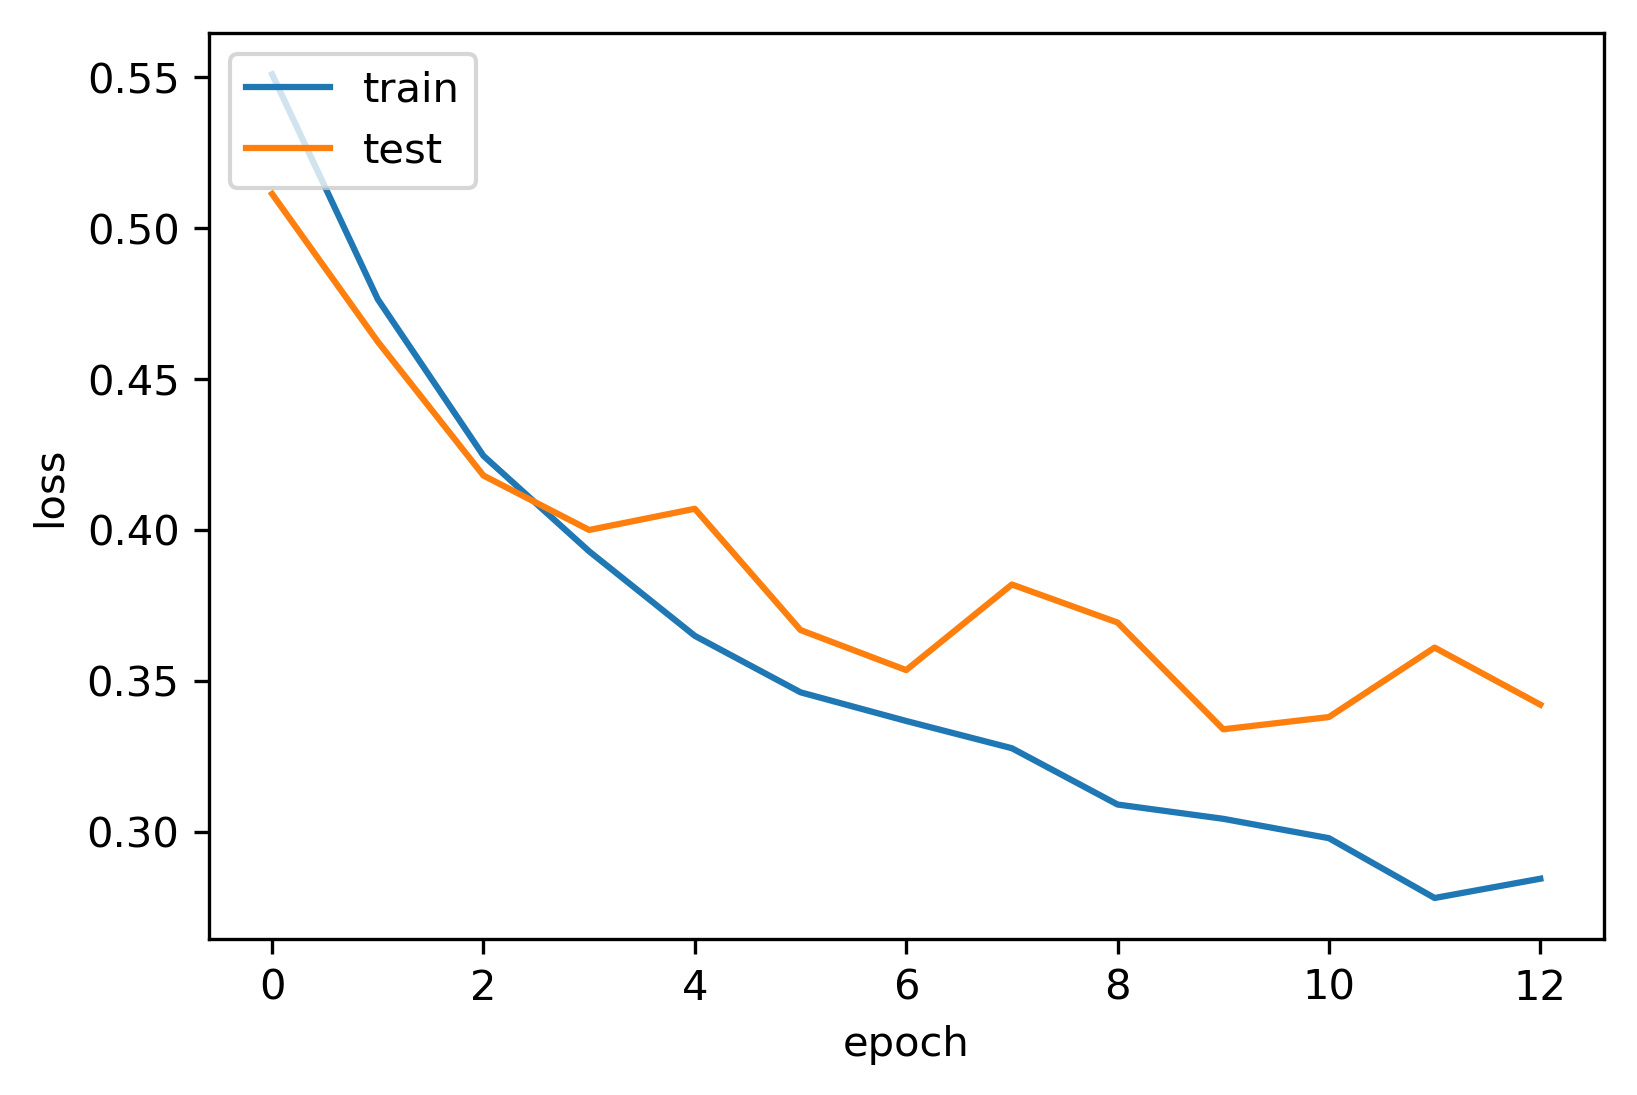

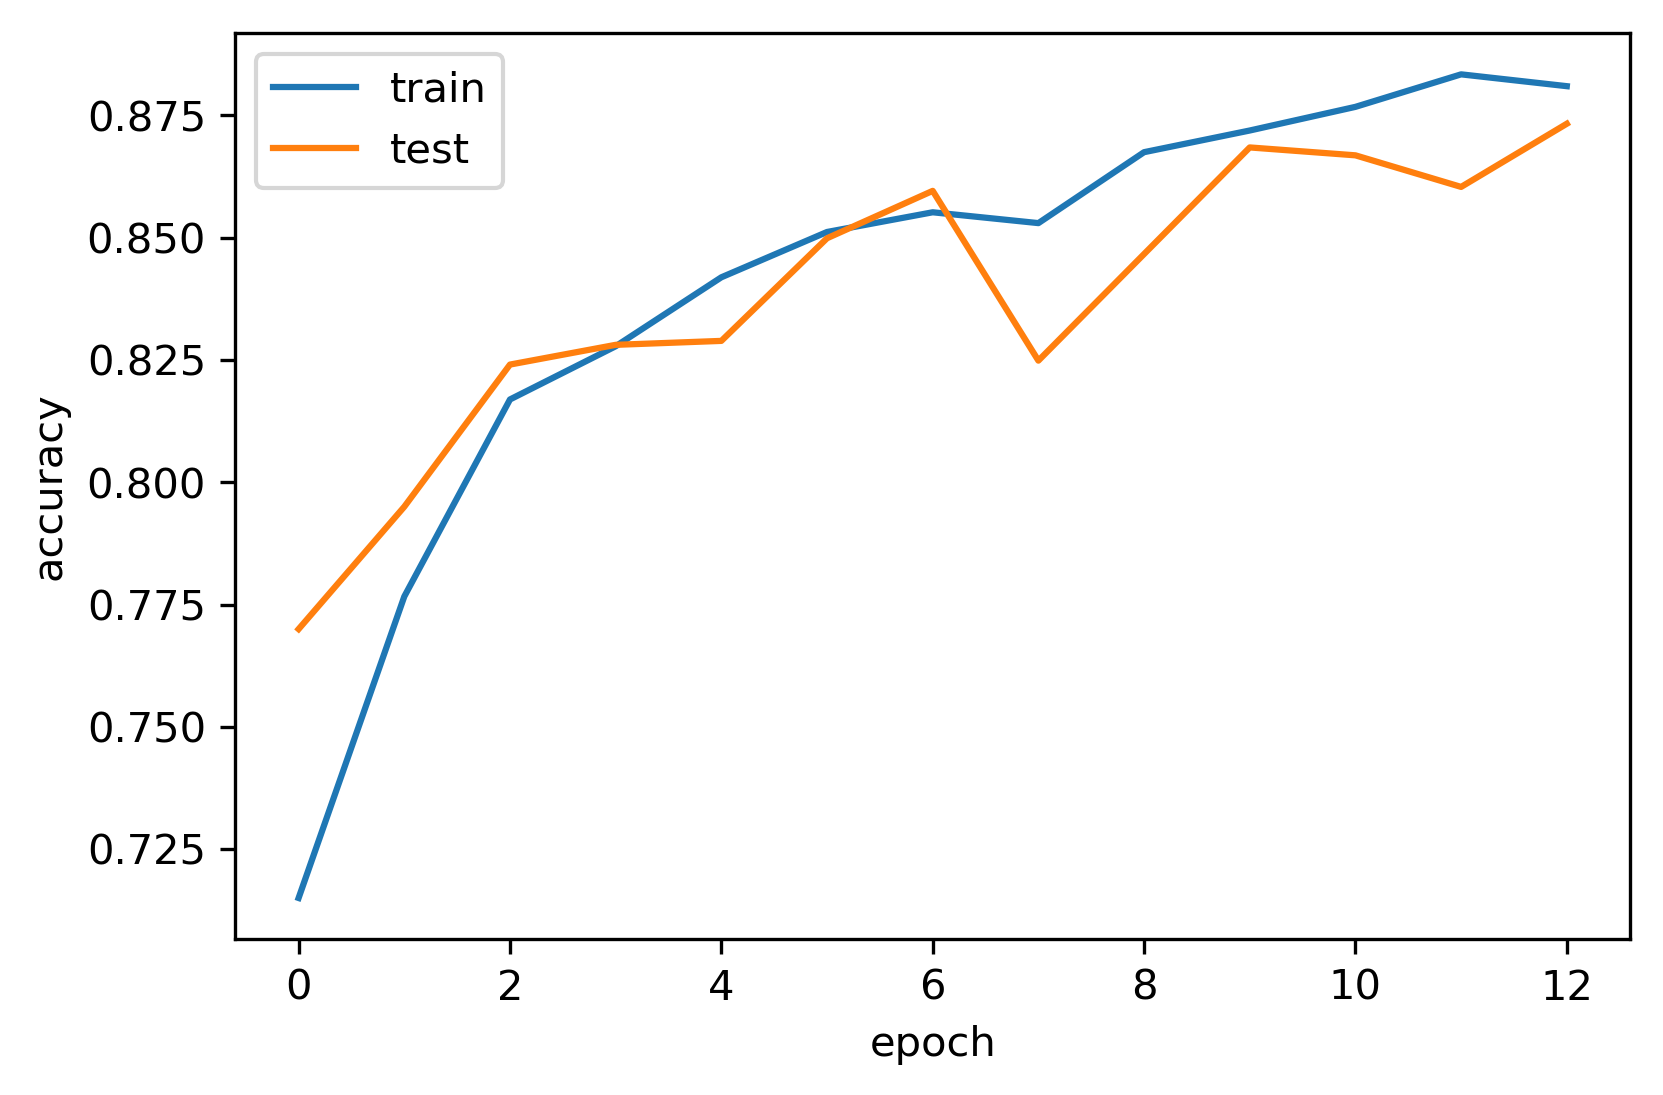

In [7]:
considered_variants = [
    {'pool': 16, 'layers': [(4, 16), (16, 16)]},
    {'pool': 16, 'layers': [(32, 16), (16, 16)]},
    {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]},
    {'pool': 64, 'layers': [(32, 64), (16, 64)]},
]

for i, variant in enumerate(considered_variants):
    print("Test convolutional network with parameters {}:".format(variant))
    filename = network_name('conv_' + str(i))
    trained = tester.test_model(conv_network(**variant), max_epochs=50)
    trained.save(filename)